In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.networks.nets import UNETR
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import logging
logging.disable(logging.WARNING)

import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmppn2c38km


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)

torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
#Frequncy UNETR

In [5]:
#fold 0
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset13/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.09s/it]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_onmiccai13_fold0_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold0_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=3.86701): 100%|█| 24/24 [00:14<00:00,  1.70it/
Training (47 / 25000 Steps) (loss=3.86601): 100%|█| 24/24 [00:11<00:00,  2.01it/
Training (71 / 25000 Steps) (loss=3.74025): 100%|█| 24/24 [00:11<00:00,  2.00it/
Training (95 / 25000 Steps) (loss=3.60771): 100%|█| 24/24 [00:11<00:00,  2.01it/
Training (119 / 25000 Steps) (loss=3.53493): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (143 / 25000 Steps) (loss=3.75298): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (167 / 25000 Steps) (loss=3.43730): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (191 / 25000 Steps) (loss=3.60932): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (215 / 25000 Steps) (loss=3.47467): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (239 / 25000 Steps) (loss=3.43441): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (263 / 25000 Steps) (loss=3.19625): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (287 / 25000 Steps) (loss=3.28911): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.2854340076446533 Current Avg. Dice: 0.2854340076446533


Training (503 / 25000 Steps) (loss=2.88769): 100%|█| 24/24 [00:16<00:00,  1.44it
Training (527 / 25000 Steps) (loss=2.90330): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (551 / 25000 Steps) (loss=2.73493): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (575 / 25000 Steps) (loss=2.85287): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (599 / 25000 Steps) (loss=2.73874): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (623 / 25000 Steps) (loss=2.76689): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (647 / 25000 Steps) (loss=2.94239): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (671 / 25000 Steps) (loss=2.79641): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (695 / 25000 Steps) (loss=2.53513): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (719 / 25000 Steps) (loss=2.58238): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (743 / 25000 Steps) (loss=2.76712): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (767 / 25000 Steps) (loss=2.71457): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.2854340076446533 Current Avg. Dice: 0.2357274293899536


Training (1007 / 25000 Steps) (loss=2.35993): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (1031 / 25000 Steps) (loss=2.26919): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1055 / 25000 Steps) (loss=2.48140): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1079 / 25000 Steps) (loss=2.11217): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1103 / 25000 Steps) (loss=2.32708): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1127 / 25000 Steps) (loss=2.16187): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1151 / 25000 Steps) (loss=2.14005): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1175 / 25000 Steps) (loss=1.93570): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1199 / 25000 Steps) (loss=2.18471): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1223 / 25000 Steps) (loss=2.28828): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1247 / 25000 Steps) (loss=2.05008): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1271 / 25000 Steps) (loss=2.14830): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.43513059616088867 Current Avg. Dice: 0.43513059616088867


Training (1511 / 25000 Steps) (loss=2.33706): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (1535 / 25000 Steps) (loss=1.81085): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1559 / 25000 Steps) (loss=1.93743): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1583 / 25000 Steps) (loss=1.92609): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1607 / 25000 Steps) (loss=1.94704): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1631 / 25000 Steps) (loss=1.81317): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1655 / 25000 Steps) (loss=1.72066): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1679 / 25000 Steps) (loss=1.66954): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1703 / 25000 Steps) (loss=1.75543): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1727 / 25000 Steps) (loss=1.86218): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1751 / 25000 Steps) (loss=1.48830): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1775 / 25000 Steps) (loss=1.63326): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.45154085755348206 Current Avg. Dice: 0.45154085755348206


Training (2015 / 25000 Steps) (loss=2.08264): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (2039 / 25000 Steps) (loss=1.53931): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2063 / 25000 Steps) (loss=1.97862): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2087 / 25000 Steps) (loss=1.42401): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2111 / 25000 Steps) (loss=1.46553): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2135 / 25000 Steps) (loss=1.44777): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2159 / 25000 Steps) (loss=1.43621): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2183 / 25000 Steps) (loss=1.36350): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2207 / 25000 Steps) (loss=1.50550): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2231 / 25000 Steps) (loss=1.51195): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2255 / 25000 Steps) (loss=1.37752): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2279 / 25000 Steps) (loss=1.36282): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.45154085755348206 Current Avg. Dice: 0.41011038422584534


Training (2519 / 25000 Steps) (loss=1.42003): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (2543 / 25000 Steps) (loss=1.36190): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2567 / 25000 Steps) (loss=1.28748): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2591 / 25000 Steps) (loss=1.37465): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2615 / 25000 Steps) (loss=1.56435): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2639 / 25000 Steps) (loss=1.33712): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2663 / 25000 Steps) (loss=1.42332): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2687 / 25000 Steps) (loss=1.59527): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2711 / 25000 Steps) (loss=1.42675): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2735 / 25000 Steps) (loss=1.45223): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2759 / 25000 Steps) (loss=1.27680): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2783 / 25000 Steps) (loss=1.31682): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.45154085755348206 Current Avg. Dice: 0.37947341799736023


Training (3023 / 25000 Steps) (loss=1.32100): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (3047 / 25000 Steps) (loss=1.19237): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3071 / 25000 Steps) (loss=1.43250): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3095 / 25000 Steps) (loss=1.38053): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3119 / 25000 Steps) (loss=1.35477): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3143 / 25000 Steps) (loss=1.19041): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3167 / 25000 Steps) (loss=1.29415): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3191 / 25000 Steps) (loss=1.16967): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3215 / 25000 Steps) (loss=1.40977): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3239 / 25000 Steps) (loss=1.34464): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3263 / 25000 Steps) (loss=1.24080): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3287 / 25000 Steps) (loss=1.43262): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.45154085755348206 Current Avg. Dice: 0.34809958934783936


Training (3503 / 25000 Steps) (loss=1.39421): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (3527 / 25000 Steps) (loss=1.29961): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3551 / 25000 Steps) (loss=1.25569): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3575 / 25000 Steps) (loss=1.22407): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3599 / 25000 Steps) (loss=1.20955): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3623 / 25000 Steps) (loss=1.31064): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3647 / 25000 Steps) (loss=1.18217): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3671 / 25000 Steps) (loss=1.22030): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3695 / 25000 Steps) (loss=1.25911): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3719 / 25000 Steps) (loss=1.20005): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3743 / 25000 Steps) (loss=1.12732): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3767 / 25000 Steps) (loss=1.05717): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.45154085755348206 Current Avg. Dice: 0.4017202854156494


Training (4007 / 25000 Steps) (loss=1.12815): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (4031 / 25000 Steps) (loss=1.26908): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4055 / 25000 Steps) (loss=1.23034): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4079 / 25000 Steps) (loss=1.28117): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4103 / 25000 Steps) (loss=1.33994): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4127 / 25000 Steps) (loss=1.36592): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4151 / 25000 Steps) (loss=1.11198): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4175 / 25000 Steps) (loss=1.29620): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4199 / 25000 Steps) (loss=2.36123): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4223 / 25000 Steps) (loss=1.40978): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4247 / 25000 Steps) (loss=1.11806): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4271 / 25000 Steps) (loss=1.11447): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.45154085755348206 Current Avg. Dice: 0.3746367394924164


Training (4511 / 25000 Steps) (loss=1.06118): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (4535 / 25000 Steps) (loss=1.09430): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4559 / 25000 Steps) (loss=1.36029): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4583 / 25000 Steps) (loss=1.15927): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4607 / 25000 Steps) (loss=1.20566): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4631 / 25000 Steps) (loss=1.05177): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4655 / 25000 Steps) (loss=1.45825): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4679 / 25000 Steps) (loss=1.07524): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4703 / 25000 Steps) (loss=1.16823): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4727 / 25000 Steps) (loss=1.23517): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4751 / 25000 Steps) (loss=1.11094): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4775 / 25000 Steps) (loss=1.05882): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.45154085755348206 Current Avg. Dice: 0.4474555253982544


Training (5015 / 25000 Steps) (loss=1.11137): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (5039 / 25000 Steps) (loss=1.07758): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5063 / 25000 Steps) (loss=1.02584): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5087 / 25000 Steps) (loss=1.24454): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5111 / 25000 Steps) (loss=1.13960): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5135 / 25000 Steps) (loss=1.15045): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5159 / 25000 Steps) (loss=1.11509): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5183 / 25000 Steps) (loss=1.05355): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5207 / 25000 Steps) (loss=1.15005): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5231 / 25000 Steps) (loss=1.03006): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5255 / 25000 Steps) (loss=1.00757): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5279 / 25000 Steps) (loss=1.38912): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.45154085755348206 Current Avg. Dice: 0.43220391869544983


Training (5519 / 25000 Steps) (loss=1.09883): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (5543 / 25000 Steps) (loss=1.09285): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5567 / 25000 Steps) (loss=1.16348): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5591 / 25000 Steps) (loss=1.09508): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5615 / 25000 Steps) (loss=1.11165): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5639 / 25000 Steps) (loss=1.03824): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5663 / 25000 Steps) (loss=1.16917): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5687 / 25000 Steps) (loss=1.22259): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5711 / 25000 Steps) (loss=1.06419): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5735 / 25000 Steps) (loss=1.23228): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5759 / 25000 Steps) (loss=1.12002): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5783 / 25000 Steps) (loss=1.07264): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4767608344554901 Current Avg. Dice: 0.4767608344554901


Training (6023 / 25000 Steps) (loss=1.01274): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (6047 / 25000 Steps) (loss=1.19415): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6071 / 25000 Steps) (loss=1.04337): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6095 / 25000 Steps) (loss=1.11272): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6119 / 25000 Steps) (loss=1.36572): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6143 / 25000 Steps) (loss=1.06882): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6167 / 25000 Steps) (loss=1.13367): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6191 / 25000 Steps) (loss=1.20813): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6215 / 25000 Steps) (loss=1.08962): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6239 / 25000 Steps) (loss=0.96264): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6263 / 25000 Steps) (loss=1.12265): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6287 / 25000 Steps) (loss=1.13103): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4767608344554901 Current Avg. Dice: 0.43682265281677246


Training (6503 / 25000 Steps) (loss=1.26130): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (6527 / 25000 Steps) (loss=1.01272): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6551 / 25000 Steps) (loss=1.26207): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6575 / 25000 Steps) (loss=1.09429): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6599 / 25000 Steps) (loss=0.97956): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6623 / 25000 Steps) (loss=1.04525): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6647 / 25000 Steps) (loss=1.06971): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6671 / 25000 Steps) (loss=1.21726): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6695 / 25000 Steps) (loss=0.98139): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6719 / 25000 Steps) (loss=1.09271): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6743 / 25000 Steps) (loss=0.99477): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6767 / 25000 Steps) (loss=0.98734): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4767608344554901 Current Avg. Dice: 0.4000512361526489


Training (7007 / 25000 Steps) (loss=1.12275): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (7031 / 25000 Steps) (loss=0.97993): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7055 / 25000 Steps) (loss=1.12360): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7079 / 25000 Steps) (loss=1.11103): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7103 / 25000 Steps) (loss=1.07981): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7127 / 25000 Steps) (loss=1.15103): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7151 / 25000 Steps) (loss=0.93938): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7175 / 25000 Steps) (loss=0.99968): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7199 / 25000 Steps) (loss=1.77767): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7223 / 25000 Steps) (loss=1.07001): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7247 / 25000 Steps) (loss=1.04303): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7271 / 25000 Steps) (loss=0.98069): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5444282293319702 Current Avg. Dice: 0.5444282293319702


Training (7511 / 25000 Steps) (loss=1.10754): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (7535 / 25000 Steps) (loss=0.95896): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7559 / 25000 Steps) (loss=1.02863): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7583 / 25000 Steps) (loss=1.06384): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7607 / 25000 Steps) (loss=1.06584): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7631 / 25000 Steps) (loss=1.05541): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7655 / 25000 Steps) (loss=1.00874): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7679 / 25000 Steps) (loss=0.97255): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7703 / 25000 Steps) (loss=0.90150): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7727 / 25000 Steps) (loss=1.09719): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7751 / 25000 Steps) (loss=0.98001): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7775 / 25000 Steps) (loss=0.99140): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5444282293319702 Current Avg. Dice: 0.4779113531112671


Training (8015 / 25000 Steps) (loss=0.94462): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (8039 / 25000 Steps) (loss=0.95878): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8063 / 25000 Steps) (loss=0.94261): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8087 / 25000 Steps) (loss=1.08280): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8111 / 25000 Steps) (loss=1.01312): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8135 / 25000 Steps) (loss=1.29893): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8159 / 25000 Steps) (loss=0.91934): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8183 / 25000 Steps) (loss=0.94890): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8207 / 25000 Steps) (loss=0.97283): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8231 / 25000 Steps) (loss=1.00745): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8255 / 25000 Steps) (loss=1.01699): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8279 / 25000 Steps) (loss=1.04912): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5782843232154846 Current Avg. Dice: 0.5782843232154846


Training (8519 / 25000 Steps) (loss=1.10208): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (8543 / 25000 Steps) (loss=0.92917): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8567 / 25000 Steps) (loss=1.16345): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8591 / 25000 Steps) (loss=1.04166): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8615 / 25000 Steps) (loss=1.03149): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8639 / 25000 Steps) (loss=0.93193): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8663 / 25000 Steps) (loss=0.92688): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8687 / 25000 Steps) (loss=0.98248): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8711 / 25000 Steps) (loss=0.86347): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8735 / 25000 Steps) (loss=1.20867): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8759 / 25000 Steps) (loss=0.88533): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8783 / 25000 Steps) (loss=0.97713): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6276946067810059 Current Avg. Dice: 0.6276946067810059


Training (9023 / 25000 Steps) (loss=1.08046): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (9047 / 25000 Steps) (loss=0.85014): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9071 / 25000 Steps) (loss=0.92996): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9095 / 25000 Steps) (loss=0.94209): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9119 / 25000 Steps) (loss=0.88968): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9143 / 25000 Steps) (loss=0.87822): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9167 / 25000 Steps) (loss=0.90739): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9191 / 25000 Steps) (loss=0.89717): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9215 / 25000 Steps) (loss=0.85580): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9239 / 25000 Steps) (loss=1.18364): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9263 / 25000 Steps) (loss=0.82433): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9287 / 25000 Steps) (loss=1.00820): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6276946067810059 Current Avg. Dice: 0.6242683529853821


Training (9503 / 25000 Steps) (loss=0.88624): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (9527 / 25000 Steps) (loss=1.05971): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9551 / 25000 Steps) (loss=0.95658): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9575 / 25000 Steps) (loss=0.85700): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9599 / 25000 Steps) (loss=0.91400): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9623 / 25000 Steps) (loss=0.95684): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9647 / 25000 Steps) (loss=0.83861): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9671 / 25000 Steps) (loss=0.99643): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9695 / 25000 Steps) (loss=0.91559): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9719 / 25000 Steps) (loss=0.80807): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9743 / 25000 Steps) (loss=0.98202): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9767 / 25000 Steps) (loss=0.89273): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6489155292510986 Current Avg. Dice: 0.6489155292510986


Training (10007 / 25000 Steps) (loss=0.93074): 100%|█| 24/24 [00:16<00:00,  1.43
Training (10031 / 25000 Steps) (loss=0.95647): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10055 / 25000 Steps) (loss=1.24039): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10079 / 25000 Steps) (loss=0.85037): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10103 / 25000 Steps) (loss=0.88460): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10127 / 25000 Steps) (loss=1.03899): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10151 / 25000 Steps) (loss=0.82025): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10175 / 25000 Steps) (loss=1.27966): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10199 / 25000 Steps) (loss=0.86401): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10223 / 25000 Steps) (loss=0.77409): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10247 / 25000 Steps) (loss=0.90485): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10271 / 25000 Steps) (loss=0.91398): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6707635521888733 Current Avg. Dice: 0.6707635521888733


Training (10511 / 25000 Steps) (loss=0.95674): 100%|█| 24/24 [00:16<00:00,  1.43
Training (10535 / 25000 Steps) (loss=0.96078): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10559 / 25000 Steps) (loss=0.89275): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10583 / 25000 Steps) (loss=0.96580): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10607 / 25000 Steps) (loss=0.82216): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10631 / 25000 Steps) (loss=0.85055): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10655 / 25000 Steps) (loss=0.86913): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10679 / 25000 Steps) (loss=0.91886): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10703 / 25000 Steps) (loss=1.45707): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10727 / 25000 Steps) (loss=1.25104): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10751 / 25000 Steps) (loss=0.86485): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10775 / 25000 Steps) (loss=0.85758): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7289583683013916 Current Avg. Dice: 0.7289583683013916


Training (11015 / 25000 Steps) (loss=0.86040): 100%|█| 24/24 [00:16<00:00,  1.43
Training (11039 / 25000 Steps) (loss=0.92588): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11063 / 25000 Steps) (loss=0.83707): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11087 / 25000 Steps) (loss=0.87679): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11111 / 25000 Steps) (loss=0.75979): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11135 / 25000 Steps) (loss=0.76551): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11159 / 25000 Steps) (loss=0.88282): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11183 / 25000 Steps) (loss=0.66073): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11207 / 25000 Steps) (loss=1.11932): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11231 / 25000 Steps) (loss=0.78590): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11255 / 25000 Steps) (loss=0.81803): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11279 / 25000 Steps) (loss=0.82500): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7289583683013916 Current Avg. Dice: 0.604312002658844


Training (11519 / 25000 Steps) (loss=0.76163): 100%|█| 24/24 [00:13<00:00,  1.79
Training (11543 / 25000 Steps) (loss=0.87933): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11567 / 25000 Steps) (loss=0.92088): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11591 / 25000 Steps) (loss=0.92915): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11615 / 25000 Steps) (loss=0.87931): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11639 / 25000 Steps) (loss=0.77059): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11663 / 25000 Steps) (loss=0.92539): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11687 / 25000 Steps) (loss=0.84774): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11711 / 25000 Steps) (loss=0.91086): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11735 / 25000 Steps) (loss=0.91669): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11759 / 25000 Steps) (loss=0.78510): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11783 / 25000 Steps) (loss=0.92348): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7289583683013916 Current Avg. Dice: 0.6905539035797119


Training (12023 / 25000 Steps) (loss=0.71541): 100%|█| 24/24 [00:13<00:00,  1.79
Training (12047 / 25000 Steps) (loss=0.82566): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12071 / 25000 Steps) (loss=0.80013): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12095 / 25000 Steps) (loss=0.80098): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12119 / 25000 Steps) (loss=0.91433): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12143 / 25000 Steps) (loss=0.85344): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12167 / 25000 Steps) (loss=0.63600): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12191 / 25000 Steps) (loss=0.79870): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12215 / 25000 Steps) (loss=0.83244): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12239 / 25000 Steps) (loss=0.80218): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12263 / 25000 Steps) (loss=0.96909): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12287 / 25000 Steps) (loss=0.73602): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7289583683013916 Current Avg. Dice: 0.7113127708435059


Training (12503 / 25000 Steps) (loss=0.74102): 100%|█| 24/24 [00:13<00:00,  1.79
Training (12527 / 25000 Steps) (loss=0.82484): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12551 / 25000 Steps) (loss=0.80340): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12575 / 25000 Steps) (loss=0.83581): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12599 / 25000 Steps) (loss=0.82594): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12623 / 25000 Steps) (loss=0.72755): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12647 / 25000 Steps) (loss=0.81876): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12671 / 25000 Steps) (loss=0.83627): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12695 / 25000 Steps) (loss=0.77376): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12719 / 25000 Steps) (loss=0.87082): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12743 / 25000 Steps) (loss=0.98699): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12767 / 25000 Steps) (loss=0.80029): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7289583683013916 Current Avg. Dice: 0.6717957854270935


Training (13007 / 25000 Steps) (loss=0.70470): 100%|█| 24/24 [00:13<00:00,  1.79
Training (13031 / 25000 Steps) (loss=0.81455): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13055 / 25000 Steps) (loss=0.84380): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13079 / 25000 Steps) (loss=0.69240): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13103 / 25000 Steps) (loss=0.81800): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13127 / 25000 Steps) (loss=0.85872): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13151 / 25000 Steps) (loss=0.92623): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13175 / 25000 Steps) (loss=0.72757): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13199 / 25000 Steps) (loss=0.91848): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13223 / 25000 Steps) (loss=0.66744): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13247 / 25000 Steps) (loss=0.83558): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13271 / 25000 Steps) (loss=0.82081): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7289583683013916 Current Avg. Dice: 0.6806819438934326


Training (13511 / 25000 Steps) (loss=0.86461): 100%|█| 24/24 [00:13<00:00,  1.79
Training (13535 / 25000 Steps) (loss=0.93132): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13559 / 25000 Steps) (loss=0.71950): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13583 / 25000 Steps) (loss=0.74773): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13607 / 25000 Steps) (loss=0.85200): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13631 / 25000 Steps) (loss=0.79924): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13655 / 25000 Steps) (loss=0.97133): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13679 / 25000 Steps) (loss=0.80517): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13703 / 25000 Steps) (loss=0.79742): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13727 / 25000 Steps) (loss=0.80275): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13751 / 25000 Steps) (loss=0.76477): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13775 / 25000 Steps) (loss=0.64194): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7289583683013916 Current Avg. Dice: 0.6456603407859802


Training (14015 / 25000 Steps) (loss=0.80574): 100%|█| 24/24 [00:13<00:00,  1.78
Training (14039 / 25000 Steps) (loss=0.79099): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14063 / 25000 Steps) (loss=0.95634): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14087 / 25000 Steps) (loss=0.74947): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14111 / 25000 Steps) (loss=0.74589): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14135 / 25000 Steps) (loss=0.76808): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14159 / 25000 Steps) (loss=0.75114): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14183 / 25000 Steps) (loss=0.76778): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14207 / 25000 Steps) (loss=0.86173): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14231 / 25000 Steps) (loss=0.90250): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14255 / 25000 Steps) (loss=0.78161): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14279 / 25000 Steps) (loss=0.75512): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7289583683013916 Current Avg. Dice: 0.6955545544624329


Training (14519 / 25000 Steps) (loss=0.72278): 100%|█| 24/24 [00:13<00:00,  1.79
Training (14543 / 25000 Steps) (loss=0.80729): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14567 / 25000 Steps) (loss=0.84997): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14591 / 25000 Steps) (loss=0.83952): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14615 / 25000 Steps) (loss=0.82022): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14639 / 25000 Steps) (loss=0.89781): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14663 / 25000 Steps) (loss=0.63286): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14687 / 25000 Steps) (loss=0.70830): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14711 / 25000 Steps) (loss=0.66642): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14735 / 25000 Steps) (loss=0.72401): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14759 / 25000 Steps) (loss=0.83130): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14783 / 25000 Steps) (loss=0.88510): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7289583683013916 Current Avg. Dice: 0.6983020901679993


Training (15023 / 25000 Steps) (loss=0.63936): 100%|█| 24/24 [00:13<00:00,  1.79
Training (15047 / 25000 Steps) (loss=0.79675): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15071 / 25000 Steps) (loss=0.68437): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15095 / 25000 Steps) (loss=0.78743): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15119 / 25000 Steps) (loss=1.23237): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15143 / 25000 Steps) (loss=0.65881): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15167 / 25000 Steps) (loss=0.88234): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15191 / 25000 Steps) (loss=0.73925): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15215 / 25000 Steps) (loss=0.86165): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15239 / 25000 Steps) (loss=0.78212): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15263 / 25000 Steps) (loss=0.75847): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15287 / 25000 Steps) (loss=0.75836): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.733146607875824 Current Avg. Dice: 0.733146607875824


Training (15503 / 25000 Steps) (loss=0.71227): 100%|█| 24/24 [00:17<00:00,  1.36
Training (15527 / 25000 Steps) (loss=0.72205): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15551 / 25000 Steps) (loss=0.84132): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15575 / 25000 Steps) (loss=0.80697): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15599 / 25000 Steps) (loss=0.74656): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15623 / 25000 Steps) (loss=0.60137): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15647 / 25000 Steps) (loss=0.73645): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15671 / 25000 Steps) (loss=0.66673): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15695 / 25000 Steps) (loss=0.85445): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15719 / 25000 Steps) (loss=0.75202): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15743 / 25000 Steps) (loss=0.76214): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15767 / 25000 Steps) (loss=0.82240): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.733146607875824 Current Avg. Dice: 0.6754785180091858


Training (16007 / 25000 Steps) (loss=0.65772): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16031 / 25000 Steps) (loss=0.87437): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16055 / 25000 Steps) (loss=0.80819): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16079 / 25000 Steps) (loss=0.81719): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16103 / 25000 Steps) (loss=0.74674): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16127 / 25000 Steps) (loss=0.85155): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16151 / 25000 Steps) (loss=1.19352): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16175 / 25000 Steps) (loss=0.79719): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16199 / 25000 Steps) (loss=0.77074): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16223 / 25000 Steps) (loss=0.80651): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16247 / 25000 Steps) (loss=0.80459): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16271 / 25000 Steps) (loss=0.85642): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.733146607875824 Current Avg. Dice: 0.728224515914917


Training (16511 / 25000 Steps) (loss=0.80108): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16535 / 25000 Steps) (loss=0.88411): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16559 / 25000 Steps) (loss=0.57931): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16583 / 25000 Steps) (loss=0.70692): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16607 / 25000 Steps) (loss=0.64756): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16631 / 25000 Steps) (loss=0.93099): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16655 / 25000 Steps) (loss=0.79061): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16679 / 25000 Steps) (loss=0.65113): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16703 / 25000 Steps) (loss=0.69957): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16727 / 25000 Steps) (loss=0.89312): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16751 / 25000 Steps) (loss=0.52581): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16775 / 25000 Steps) (loss=0.72845): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.733146607875824 Current Avg. Dice: 0.6933526992797852


Training (17015 / 25000 Steps) (loss=0.69169): 100%|█| 24/24 [00:13<00:00,  1.79
Training (17039 / 25000 Steps) (loss=0.82981): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17063 / 25000 Steps) (loss=0.59435): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17087 / 25000 Steps) (loss=0.68456): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17111 / 25000 Steps) (loss=0.58411): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17135 / 25000 Steps) (loss=0.67754): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17159 / 25000 Steps) (loss=0.70553): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17183 / 25000 Steps) (loss=0.86963): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17207 / 25000 Steps) (loss=0.64174): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17231 / 25000 Steps) (loss=0.83172): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17255 / 25000 Steps) (loss=0.55533): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17279 / 25000 Steps) (loss=0.72566): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.733146607875824 Current Avg. Dice: 0.6740029454231262


Training (17519 / 25000 Steps) (loss=0.75019): 100%|█| 24/24 [00:13<00:00,  1.79
Training (17543 / 25000 Steps) (loss=0.86031): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17567 / 25000 Steps) (loss=0.89564): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17591 / 25000 Steps) (loss=0.82982): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17615 / 25000 Steps) (loss=0.59247): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17639 / 25000 Steps) (loss=1.04007): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17663 / 25000 Steps) (loss=0.76783): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17687 / 25000 Steps) (loss=0.90619): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17711 / 25000 Steps) (loss=0.69179): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17735 / 25000 Steps) (loss=0.72862): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17759 / 25000 Steps) (loss=1.14356): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17783 / 25000 Steps) (loss=0.88667): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.733146607875824 Current Avg. Dice: 0.6619691252708435


Training (18023 / 25000 Steps) (loss=0.72707): 100%|█| 24/24 [00:13<00:00,  1.79
Training (18047 / 25000 Steps) (loss=0.84635): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18071 / 25000 Steps) (loss=0.83863): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18095 / 25000 Steps) (loss=0.80113): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18119 / 25000 Steps) (loss=0.49906): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18143 / 25000 Steps) (loss=0.82210): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18167 / 25000 Steps) (loss=0.81892): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18191 / 25000 Steps) (loss=0.74193): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18215 / 25000 Steps) (loss=0.56771): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18239 / 25000 Steps) (loss=1.22417): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18263 / 25000 Steps) (loss=0.77590): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18287 / 25000 Steps) (loss=0.74026): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.733146607875824 Current Avg. Dice: 0.7277594208717346


Training (18503 / 25000 Steps) (loss=0.84974): 100%|█| 24/24 [00:13<00:00,  1.79
Training (18527 / 25000 Steps) (loss=0.79126): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18551 / 25000 Steps) (loss=0.87899): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18575 / 25000 Steps) (loss=0.86105): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18599 / 25000 Steps) (loss=0.89027): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18623 / 25000 Steps) (loss=0.67802): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18647 / 25000 Steps) (loss=0.76429): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18671 / 25000 Steps) (loss=0.79867): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18695 / 25000 Steps) (loss=0.65261): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18719 / 25000 Steps) (loss=0.86296): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18743 / 25000 Steps) (loss=0.84155): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18767 / 25000 Steps) (loss=0.74712): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.733146607875824 Current Avg. Dice: 0.7309834957122803


Training (19007 / 25000 Steps) (loss=0.77198): 100%|█| 24/24 [00:13<00:00,  1.79
Training (19031 / 25000 Steps) (loss=0.59828): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19055 / 25000 Steps) (loss=0.67600): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19079 / 25000 Steps) (loss=0.66707): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19103 / 25000 Steps) (loss=0.64396): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19127 / 25000 Steps) (loss=0.70315): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19151 / 25000 Steps) (loss=0.73375): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19175 / 25000 Steps) (loss=0.90088): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19199 / 25000 Steps) (loss=0.64185): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19223 / 25000 Steps) (loss=0.73860): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19247 / 25000 Steps) (loss=0.62036): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19271 / 25000 Steps) (loss=0.69899): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7652028203010559 Current Avg. Dice: 0.7652028203010559


Training (19511 / 25000 Steps) (loss=0.75730): 100%|█| 24/24 [00:16<00:00,  1.42
Training (19535 / 25000 Steps) (loss=0.79933): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19559 / 25000 Steps) (loss=0.91398): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19583 / 25000 Steps) (loss=0.66938): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19607 / 25000 Steps) (loss=0.74405): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19631 / 25000 Steps) (loss=0.75104): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19655 / 25000 Steps) (loss=0.64873): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19679 / 25000 Steps) (loss=0.68827): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19703 / 25000 Steps) (loss=0.80773): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19727 / 25000 Steps) (loss=0.57616): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19751 / 25000 Steps) (loss=0.69865): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19775 / 25000 Steps) (loss=0.68212): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7652028203010559 Current Avg. Dice: 0.6745988726615906


Training (20015 / 25000 Steps) (loss=0.67458): 100%|█| 24/24 [00:13<00:00,  1.79
Training (20039 / 25000 Steps) (loss=0.64676): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20063 / 25000 Steps) (loss=0.66361): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20087 / 25000 Steps) (loss=0.74096): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20111 / 25000 Steps) (loss=0.64555): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20135 / 25000 Steps) (loss=0.72023): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20159 / 25000 Steps) (loss=0.72271): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20183 / 25000 Steps) (loss=0.70922): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20207 / 25000 Steps) (loss=0.67874): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20231 / 25000 Steps) (loss=0.68406): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20255 / 25000 Steps) (loss=0.67498): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20279 / 25000 Steps) (loss=0.53739): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7652028203010559 Current Avg. Dice: 0.7318322062492371


Training (20519 / 25000 Steps) (loss=1.11455): 100%|█| 24/24 [00:13<00:00,  1.79
Training (20543 / 25000 Steps) (loss=0.76040): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20567 / 25000 Steps) (loss=0.89680): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20591 / 25000 Steps) (loss=0.49889): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20615 / 25000 Steps) (loss=0.79845): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20639 / 25000 Steps) (loss=1.06888): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20663 / 25000 Steps) (loss=0.59075): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20687 / 25000 Steps) (loss=0.74779): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20711 / 25000 Steps) (loss=0.71666): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20735 / 25000 Steps) (loss=0.75957): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20759 / 25000 Steps) (loss=0.77388): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20783 / 25000 Steps) (loss=0.73597): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7935621738433838 Current Avg. Dice: 0.7935621738433838


Training (21023 / 25000 Steps) (loss=0.86455): 100%|█| 24/24 [00:16<00:00,  1.43
Training (21047 / 25000 Steps) (loss=0.70155): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21071 / 25000 Steps) (loss=0.80557): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21095 / 25000 Steps) (loss=0.70398): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21119 / 25000 Steps) (loss=0.83493): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21143 / 25000 Steps) (loss=0.71900): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21167 / 25000 Steps) (loss=0.81447): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21191 / 25000 Steps) (loss=0.72624): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21215 / 25000 Steps) (loss=1.05683): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21239 / 25000 Steps) (loss=0.89598): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21263 / 25000 Steps) (loss=0.68805): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21287 / 25000 Steps) (loss=0.73038): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7935621738433838 Current Avg. Dice: 0.7467862963676453


Training (21503 / 25000 Steps) (loss=0.63028): 100%|█| 24/24 [00:13<00:00,  1.79
Training (21527 / 25000 Steps) (loss=0.70648): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21551 / 25000 Steps) (loss=0.69129): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21575 / 25000 Steps) (loss=0.79407): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21599 / 25000 Steps) (loss=0.69898): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21623 / 25000 Steps) (loss=0.82503): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21647 / 25000 Steps) (loss=0.68922): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21671 / 25000 Steps) (loss=0.70482): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21695 / 25000 Steps) (loss=0.66810): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21719 / 25000 Steps) (loss=0.69921): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21743 / 25000 Steps) (loss=0.77839): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21767 / 25000 Steps) (loss=0.78519): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7935621738433838 Current Avg. Dice: 0.7708902359008789


Training (22007 / 25000 Steps) (loss=0.90805): 100%|█| 24/24 [00:13<00:00,  1.79
Training (22031 / 25000 Steps) (loss=0.57684): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22055 / 25000 Steps) (loss=0.52231): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22079 / 25000 Steps) (loss=0.74510): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22103 / 25000 Steps) (loss=0.68196): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22127 / 25000 Steps) (loss=0.55964): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22151 / 25000 Steps) (loss=0.73486): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22175 / 25000 Steps) (loss=0.62939): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22199 / 25000 Steps) (loss=0.65051): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22223 / 25000 Steps) (loss=0.61287): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22247 / 25000 Steps) (loss=0.81123): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22271 / 25000 Steps) (loss=0.43777): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7935621738433838 Current Avg. Dice: 0.7530239224433899


Training (22511 / 25000 Steps) (loss=0.60285): 100%|█| 24/24 [00:13<00:00,  1.78
Training (22535 / 25000 Steps) (loss=0.64342): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22559 / 25000 Steps) (loss=0.71333): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22583 / 25000 Steps) (loss=0.61399): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22607 / 25000 Steps) (loss=0.95776): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22631 / 25000 Steps) (loss=0.54004): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22655 / 25000 Steps) (loss=0.82253): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22679 / 25000 Steps) (loss=0.72535): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22703 / 25000 Steps) (loss=0.71837): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22727 / 25000 Steps) (loss=0.76440): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22751 / 25000 Steps) (loss=0.58197): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22775 / 25000 Steps) (loss=0.63764): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7935621738433838 Current Avg. Dice: 0.7503101825714111


Training (23015 / 25000 Steps) (loss=0.64948): 100%|█| 24/24 [00:13<00:00,  1.79
Training (23039 / 25000 Steps) (loss=0.84448): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23063 / 25000 Steps) (loss=0.88676): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23087 / 25000 Steps) (loss=0.76064): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23111 / 25000 Steps) (loss=0.62018): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23135 / 25000 Steps) (loss=0.82723): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23159 / 25000 Steps) (loss=0.80609): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23183 / 25000 Steps) (loss=0.60223): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23207 / 25000 Steps) (loss=0.70674): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23231 / 25000 Steps) (loss=0.68916): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23255 / 25000 Steps) (loss=0.63081): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23279 / 25000 Steps) (loss=0.72288): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7935621738433838 Current Avg. Dice: 0.6680662035942078


Training (23519 / 25000 Steps) (loss=0.70393): 100%|█| 24/24 [00:13<00:00,  1.79
Training (23543 / 25000 Steps) (loss=0.79625): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23567 / 25000 Steps) (loss=0.79492): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23591 / 25000 Steps) (loss=0.63455): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23615 / 25000 Steps) (loss=0.52588): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23639 / 25000 Steps) (loss=0.71947): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23663 / 25000 Steps) (loss=0.73540): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23687 / 25000 Steps) (loss=0.46448): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23711 / 25000 Steps) (loss=0.77131): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23735 / 25000 Steps) (loss=0.79965): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23759 / 25000 Steps) (loss=0.73435): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23783 / 25000 Steps) (loss=0.49957): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7935621738433838 Current Avg. Dice: 0.7706058621406555


Training (24023 / 25000 Steps) (loss=0.86654): 100%|█| 24/24 [00:13<00:00,  1.79
Training (24047 / 25000 Steps) (loss=0.44306): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24071 / 25000 Steps) (loss=0.77320): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24095 / 25000 Steps) (loss=0.86774): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24119 / 25000 Steps) (loss=0.72054): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24143 / 25000 Steps) (loss=0.58270): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24167 / 25000 Steps) (loss=0.54153): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24191 / 25000 Steps) (loss=0.71486): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24215 / 25000 Steps) (loss=0.56841): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24239 / 25000 Steps) (loss=0.54093): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24263 / 25000 Steps) (loss=0.77237): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24287 / 25000 Steps) (loss=0.69011): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.79413241147995 Current Avg. Dice: 0.79413241147995


Training (24503 / 25000 Steps) (loss=0.54132): 100%|█| 24/24 [00:16<00:00,  1.43
Training (24527 / 25000 Steps) (loss=0.58168): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24551 / 25000 Steps) (loss=0.75616): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24575 / 25000 Steps) (loss=0.77227): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24599 / 25000 Steps) (loss=0.61125): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24623 / 25000 Steps) (loss=0.62218): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24647 / 25000 Steps) (loss=0.50510): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24671 / 25000 Steps) (loss=0.82511): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24695 / 25000 Steps) (loss=0.69974): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24719 / 25000 Steps) (loss=0.48616): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24743 / 25000 Steps) (loss=0.88031): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24767 / 25000 Steps) (loss=0.74300): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.79413241147995 Current Avg. Dice: 0.7552945017814636


Training (25007 / 25000 Steps) (loss=0.82035): 100%|█| 24/24 [00:13<00:00,  1.79


In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7941 at iteration: 24500


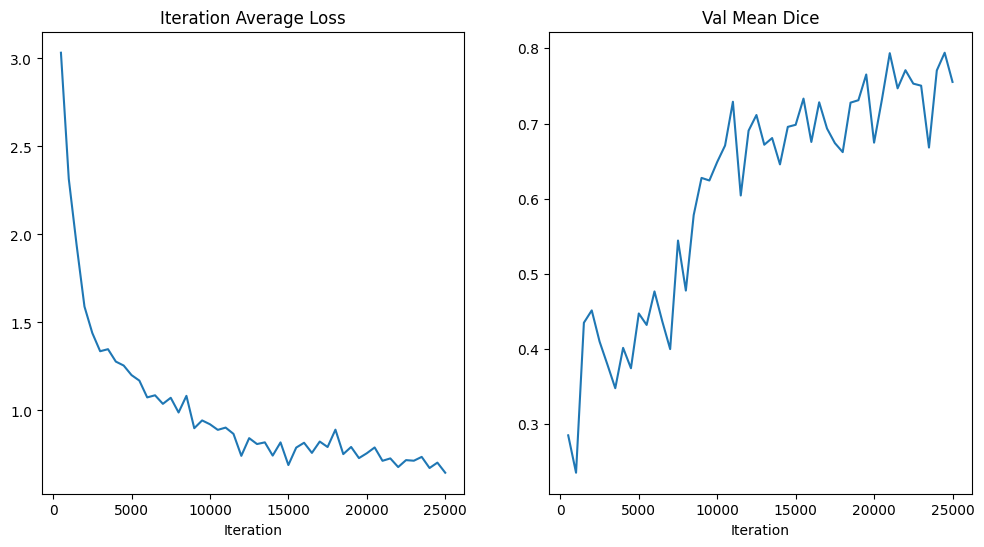

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 1
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset13/"
split_json = "dataset_1.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.36it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_onmiccai13_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=3.00420): 100%|█| 24/24 [00:13<00:00,  1.72it/
Training (47 / 25000 Steps) (loss=2.76703): 100%|█| 24/24 [00:11<00:00,  2.00it/
Training (71 / 25000 Steps) (loss=2.82596): 100%|█| 24/24 [00:11<00:00,  2.01it/
Training (95 / 25000 Steps) (loss=2.68865): 100%|█| 24/24 [00:11<00:00,  2.00it/
Training (119 / 25000 Steps) (loss=2.66514): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (143 / 25000 Steps) (loss=2.58816): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (167 / 25000 Steps) (loss=2.60059): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (191 / 25000 Steps) (loss=2.44308): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (215 / 25000 Steps) (loss=2.41613): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (239 / 25000 Steps) (loss=2.46184): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (263 / 25000 Steps) (loss=2.33396): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (287 / 25000 Steps) (loss=2.25012): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.1960800439119339 Current Avg. Dice: 0.1960800439119339


Training (503 / 25000 Steps) (loss=2.04474): 100%|█| 24/24 [00:16<00:00,  1.46it
Training (527 / 25000 Steps) (loss=2.14239): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (551 / 25000 Steps) (loss=2.23456): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (575 / 25000 Steps) (loss=2.06860): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (599 / 25000 Steps) (loss=1.91931): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (623 / 25000 Steps) (loss=2.12405): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (647 / 25000 Steps) (loss=2.00889): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (671 / 25000 Steps) (loss=1.95403): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (695 / 25000 Steps) (loss=1.90102): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (719 / 25000 Steps) (loss=1.96131): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (743 / 25000 Steps) (loss=1.91817): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (767 / 25000 Steps) (loss=1.78227): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.32288655638694763 Current Avg. Dice: 0.32288655638694763


Training (1007 / 25000 Steps) (loss=1.55528): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (1031 / 25000 Steps) (loss=1.67287): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1055 / 25000 Steps) (loss=1.51027): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1079 / 25000 Steps) (loss=1.56194): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1103 / 25000 Steps) (loss=1.48170): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1127 / 25000 Steps) (loss=1.49572): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1151 / 25000 Steps) (loss=1.56249): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1175 / 25000 Steps) (loss=1.54083): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1199 / 25000 Steps) (loss=1.73546): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1223 / 25000 Steps) (loss=1.61091): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1247 / 25000 Steps) (loss=1.81088): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1271 / 25000 Steps) (loss=1.50416): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.32823193073272705 Current Avg. Dice: 0.32823193073272705


Training (1511 / 25000 Steps) (loss=1.54228): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (1535 / 25000 Steps) (loss=1.27395): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1559 / 25000 Steps) (loss=1.27429): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1583 / 25000 Steps) (loss=1.33921): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1607 / 25000 Steps) (loss=1.34291): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1631 / 25000 Steps) (loss=1.44171): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1655 / 25000 Steps) (loss=1.33458): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1679 / 25000 Steps) (loss=1.61582): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1703 / 25000 Steps) (loss=1.46508): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1727 / 25000 Steps) (loss=1.27047): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1751 / 25000 Steps) (loss=1.50260): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1775 / 25000 Steps) (loss=1.20490): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.32823193073272705 Current Avg. Dice: 0.3131386339664459


Training (2015 / 25000 Steps) (loss=1.28182): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (2039 / 25000 Steps) (loss=1.20529): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2063 / 25000 Steps) (loss=1.25185): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2087 / 25000 Steps) (loss=1.20732): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2111 / 25000 Steps) (loss=1.14668): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2135 / 25000 Steps) (loss=1.29247): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2159 / 25000 Steps) (loss=1.35770): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2183 / 25000 Steps) (loss=1.29266): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2207 / 25000 Steps) (loss=1.22574): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2231 / 25000 Steps) (loss=1.26597): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2255 / 25000 Steps) (loss=1.38056): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2279 / 25000 Steps) (loss=1.34398): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4350603520870209 Current Avg. Dice: 0.4350603520870209


Training (2519 / 25000 Steps) (loss=1.19294): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (2543 / 25000 Steps) (loss=1.77353): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2567 / 25000 Steps) (loss=1.20809): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2591 / 25000 Steps) (loss=1.21093): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2615 / 25000 Steps) (loss=1.26021): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2639 / 25000 Steps) (loss=1.31955): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2663 / 25000 Steps) (loss=1.19775): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2687 / 25000 Steps) (loss=1.33638): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2711 / 25000 Steps) (loss=1.32753): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2735 / 25000 Steps) (loss=1.21346): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2759 / 25000 Steps) (loss=1.08918): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2783 / 25000 Steps) (loss=1.31572): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4350603520870209 Current Avg. Dice: 0.29680827260017395


Training (3023 / 25000 Steps) (loss=1.24071): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (3047 / 25000 Steps) (loss=1.16819): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3071 / 25000 Steps) (loss=1.39170): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3095 / 25000 Steps) (loss=1.16517): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3119 / 25000 Steps) (loss=1.21156): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3143 / 25000 Steps) (loss=1.20513): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3167 / 25000 Steps) (loss=1.13782): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3191 / 25000 Steps) (loss=1.36484): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3215 / 25000 Steps) (loss=1.31505): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3239 / 25000 Steps) (loss=1.36481): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3263 / 25000 Steps) (loss=1.44994): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3287 / 25000 Steps) (loss=1.17810): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4350603520870209 Current Avg. Dice: 0.3807545006275177


Training (3503 / 25000 Steps) (loss=1.39263): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (3527 / 25000 Steps) (loss=1.27478): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3551 / 25000 Steps) (loss=1.15805): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3575 / 25000 Steps) (loss=1.17452): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3599 / 25000 Steps) (loss=1.24371): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3623 / 25000 Steps) (loss=1.19786): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3647 / 25000 Steps) (loss=1.07517): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3671 / 25000 Steps) (loss=1.01194): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3695 / 25000 Steps) (loss=1.17248): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3719 / 25000 Steps) (loss=1.12290): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3743 / 25000 Steps) (loss=1.17764): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3767 / 25000 Steps) (loss=1.22728): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4350603520870209 Current Avg. Dice: 0.34721824526786804


Training (4007 / 25000 Steps) (loss=1.32139): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (4031 / 25000 Steps) (loss=1.14752): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4055 / 25000 Steps) (loss=1.23274): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4079 / 25000 Steps) (loss=1.19252): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4103 / 25000 Steps) (loss=1.05359): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4127 / 25000 Steps) (loss=1.08397): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4151 / 25000 Steps) (loss=1.54513): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4175 / 25000 Steps) (loss=1.08572): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4199 / 25000 Steps) (loss=1.16565): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4223 / 25000 Steps) (loss=1.00296): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4247 / 25000 Steps) (loss=1.12229): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4271 / 25000 Steps) (loss=1.98755): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.466043621301651 Current Avg. Dice: 0.466043621301651


Training (4511 / 25000 Steps) (loss=0.98520): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (4535 / 25000 Steps) (loss=1.09365): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4559 / 25000 Steps) (loss=1.06797): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4583 / 25000 Steps) (loss=1.05255): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4607 / 25000 Steps) (loss=1.02401): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4631 / 25000 Steps) (loss=1.33536): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4655 / 25000 Steps) (loss=1.01540): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4679 / 25000 Steps) (loss=1.02691): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4703 / 25000 Steps) (loss=1.12927): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4727 / 25000 Steps) (loss=1.09997): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4751 / 25000 Steps) (loss=1.25862): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4775 / 25000 Steps) (loss=0.99501): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4702833890914917 Current Avg. Dice: 0.4702833890914917


Training (5015 / 25000 Steps) (loss=1.03726): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (5039 / 25000 Steps) (loss=1.02572): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5063 / 25000 Steps) (loss=1.19999): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5087 / 25000 Steps) (loss=1.06417): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5111 / 25000 Steps) (loss=1.11819): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5135 / 25000 Steps) (loss=0.97871): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5159 / 25000 Steps) (loss=0.97375): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5183 / 25000 Steps) (loss=0.94644): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5207 / 25000 Steps) (loss=0.98771): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5231 / 25000 Steps) (loss=1.17053): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5255 / 25000 Steps) (loss=1.16210): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5279 / 25000 Steps) (loss=1.05102): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.48637422919273376 Current Avg. Dice: 0.48637422919273376


Training (5519 / 25000 Steps) (loss=0.96090): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (5543 / 25000 Steps) (loss=1.11818): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5567 / 25000 Steps) (loss=1.13790): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5591 / 25000 Steps) (loss=1.10184): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5615 / 25000 Steps) (loss=1.20765): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5639 / 25000 Steps) (loss=1.05327): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5663 / 25000 Steps) (loss=1.00089): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5687 / 25000 Steps) (loss=0.95870): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5711 / 25000 Steps) (loss=1.15631): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5735 / 25000 Steps) (loss=1.04292): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5759 / 25000 Steps) (loss=1.85588): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5783 / 25000 Steps) (loss=0.98692): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.48637422919273376 Current Avg. Dice: 0.47764524817466736


Training (6023 / 25000 Steps) (loss=1.06422): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (6047 / 25000 Steps) (loss=0.96659): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6071 / 25000 Steps) (loss=0.95988): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6095 / 25000 Steps) (loss=1.08584): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6119 / 25000 Steps) (loss=1.22121): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6143 / 25000 Steps) (loss=0.95333): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6167 / 25000 Steps) (loss=0.95107): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6191 / 25000 Steps) (loss=0.94517): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6215 / 25000 Steps) (loss=1.00473): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6239 / 25000 Steps) (loss=0.92512): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6263 / 25000 Steps) (loss=1.08454): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6287 / 25000 Steps) (loss=1.32999): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.48637422919273376 Current Avg. Dice: 0.4151877462863922


Training (6503 / 25000 Steps) (loss=0.97345): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (6527 / 25000 Steps) (loss=1.18399): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6551 / 25000 Steps) (loss=1.02793): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6575 / 25000 Steps) (loss=1.15327): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6599 / 25000 Steps) (loss=1.07500): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6623 / 25000 Steps) (loss=0.98868): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6647 / 25000 Steps) (loss=0.99167): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6671 / 25000 Steps) (loss=0.91362): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6695 / 25000 Steps) (loss=1.06782): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6719 / 25000 Steps) (loss=1.01397): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6743 / 25000 Steps) (loss=0.94905): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6767 / 25000 Steps) (loss=1.04810): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.48637422919273376 Current Avg. Dice: 0.47693267464637756


Training (7007 / 25000 Steps) (loss=0.89516): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (7031 / 25000 Steps) (loss=1.06745): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7055 / 25000 Steps) (loss=0.90711): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7079 / 25000 Steps) (loss=1.16069): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7103 / 25000 Steps) (loss=1.04183): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7127 / 25000 Steps) (loss=0.94054): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7151 / 25000 Steps) (loss=0.94133): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7175 / 25000 Steps) (loss=0.94146): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7199 / 25000 Steps) (loss=1.07147): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7223 / 25000 Steps) (loss=0.89947): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7247 / 25000 Steps) (loss=1.03146): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7271 / 25000 Steps) (loss=1.03150): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5779154300689697 Current Avg. Dice: 0.5779154300689697


Training (7511 / 25000 Steps) (loss=0.95374): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (7535 / 25000 Steps) (loss=0.86178): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7559 / 25000 Steps) (loss=1.04171): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7583 / 25000 Steps) (loss=1.01515): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7607 / 25000 Steps) (loss=1.10569): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7631 / 25000 Steps) (loss=1.10897): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7655 / 25000 Steps) (loss=0.91487): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7679 / 25000 Steps) (loss=1.29966): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7703 / 25000 Steps) (loss=0.94762): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7727 / 25000 Steps) (loss=0.98345): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7751 / 25000 Steps) (loss=0.89163): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7775 / 25000 Steps) (loss=0.92636): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5779154300689697 Current Avg. Dice: 0.472513347864151


Training (8015 / 25000 Steps) (loss=0.97021): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (8039 / 25000 Steps) (loss=0.93965): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8063 / 25000 Steps) (loss=1.04464): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8087 / 25000 Steps) (loss=0.98897): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8111 / 25000 Steps) (loss=0.91872): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8135 / 25000 Steps) (loss=0.90609): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8159 / 25000 Steps) (loss=1.22780): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8183 / 25000 Steps) (loss=0.90462): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8207 / 25000 Steps) (loss=0.90996): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8231 / 25000 Steps) (loss=0.88834): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8255 / 25000 Steps) (loss=0.94450): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8279 / 25000 Steps) (loss=0.94302): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5779154300689697 Current Avg. Dice: 0.4907754957675934


Training (8519 / 25000 Steps) (loss=0.94421): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (8543 / 25000 Steps) (loss=0.91985): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8567 / 25000 Steps) (loss=0.91375): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8591 / 25000 Steps) (loss=1.13970): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8615 / 25000 Steps) (loss=0.89785): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8639 / 25000 Steps) (loss=0.96893): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8663 / 25000 Steps) (loss=0.92310): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8687 / 25000 Steps) (loss=0.91743): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8711 / 25000 Steps) (loss=0.94792): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8735 / 25000 Steps) (loss=0.93266): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8759 / 25000 Steps) (loss=0.96992): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8783 / 25000 Steps) (loss=0.88992): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5779154300689697 Current Avg. Dice: 0.5565264821052551


Training (9023 / 25000 Steps) (loss=1.01542): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (9047 / 25000 Steps) (loss=0.91045): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9071 / 25000 Steps) (loss=0.88367): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9095 / 25000 Steps) (loss=0.93733): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9119 / 25000 Steps) (loss=0.86296): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9143 / 25000 Steps) (loss=0.87125): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9167 / 25000 Steps) (loss=0.85655): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9191 / 25000 Steps) (loss=1.05748): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9215 / 25000 Steps) (loss=0.91670): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9239 / 25000 Steps) (loss=0.90146): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9263 / 25000 Steps) (loss=0.86881): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9287 / 25000 Steps) (loss=0.86771): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6264156699180603 Current Avg. Dice: 0.6264156699180603


Training (9503 / 25000 Steps) (loss=0.98903): 100%|█| 24/24 [00:16<00:00,  1.44i
Training (9527 / 25000 Steps) (loss=0.92878): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9551 / 25000 Steps) (loss=0.87662): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9575 / 25000 Steps) (loss=0.93045): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9599 / 25000 Steps) (loss=0.83696): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9623 / 25000 Steps) (loss=0.83653): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9647 / 25000 Steps) (loss=0.88721): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9671 / 25000 Steps) (loss=1.40033): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9695 / 25000 Steps) (loss=0.89499): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9719 / 25000 Steps) (loss=0.83801): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9743 / 25000 Steps) (loss=0.87808): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9767 / 25000 Steps) (loss=0.78351): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6264156699180603 Current Avg. Dice: 0.524267852306366


Training (10007 / 25000 Steps) (loss=0.95943): 100%|█| 24/24 [00:13<00:00,  1.80
Training (10031 / 25000 Steps) (loss=1.05113): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10055 / 25000 Steps) (loss=1.38033): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10079 / 25000 Steps) (loss=0.87640): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10103 / 25000 Steps) (loss=0.91940): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10127 / 25000 Steps) (loss=0.96148): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10151 / 25000 Steps) (loss=0.95823): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10175 / 25000 Steps) (loss=1.02278): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10199 / 25000 Steps) (loss=0.91760): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10223 / 25000 Steps) (loss=0.87855): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10247 / 25000 Steps) (loss=0.88846): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10271 / 25000 Steps) (loss=0.91139): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6264156699180603 Current Avg. Dice: 0.624505341053009


Training (10511 / 25000 Steps) (loss=0.98892): 100%|█| 24/24 [00:13<00:00,  1.80
Training (10535 / 25000 Steps) (loss=0.84618): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10559 / 25000 Steps) (loss=0.91341): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10583 / 25000 Steps) (loss=0.95523): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10607 / 25000 Steps) (loss=0.76893): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10631 / 25000 Steps) (loss=0.83479): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10655 / 25000 Steps) (loss=1.04158): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10679 / 25000 Steps) (loss=0.84331): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10703 / 25000 Steps) (loss=0.80256): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10727 / 25000 Steps) (loss=0.93423): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10751 / 25000 Steps) (loss=0.82929): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10775 / 25000 Steps) (loss=0.89892): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6264156699180603 Current Avg. Dice: 0.6225535869598389


Training (11015 / 25000 Steps) (loss=0.86941): 100%|█| 24/24 [00:13<00:00,  1.80
Training (11039 / 25000 Steps) (loss=0.82503): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11063 / 25000 Steps) (loss=0.71891): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11087 / 25000 Steps) (loss=0.72985): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11111 / 25000 Steps) (loss=0.78094): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11135 / 25000 Steps) (loss=0.89952): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11159 / 25000 Steps) (loss=1.08725): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11183 / 25000 Steps) (loss=0.80483): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11207 / 25000 Steps) (loss=0.75121): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11231 / 25000 Steps) (loss=1.39889): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11255 / 25000 Steps) (loss=0.85151): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11279 / 25000 Steps) (loss=0.94261): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6264156699180603 Current Avg. Dice: 0.5938442349433899


Training (11519 / 25000 Steps) (loss=0.90784): 100%|█| 24/24 [00:13<00:00,  1.80
Training (11543 / 25000 Steps) (loss=0.99605): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11567 / 25000 Steps) (loss=0.83278): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11591 / 25000 Steps) (loss=0.99121): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11615 / 25000 Steps) (loss=0.81259): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11639 / 25000 Steps) (loss=0.86742): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11663 / 25000 Steps) (loss=0.94401): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11687 / 25000 Steps) (loss=1.42764): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11711 / 25000 Steps) (loss=0.90180): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11735 / 25000 Steps) (loss=0.89625): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11759 / 25000 Steps) (loss=0.88976): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11783 / 25000 Steps) (loss=0.94287): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6987372040748596 Current Avg. Dice: 0.6987372040748596


Training (12023 / 25000 Steps) (loss=0.77347): 100%|█| 24/24 [00:16<00:00,  1.43
Training (12047 / 25000 Steps) (loss=0.81841): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12071 / 25000 Steps) (loss=0.81661): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12095 / 25000 Steps) (loss=0.89509): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12119 / 25000 Steps) (loss=0.71966): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12143 / 25000 Steps) (loss=0.89057): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12167 / 25000 Steps) (loss=0.90183): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12191 / 25000 Steps) (loss=0.77534): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12215 / 25000 Steps) (loss=0.78322): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12239 / 25000 Steps) (loss=0.78902): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12263 / 25000 Steps) (loss=0.83998): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12287 / 25000 Steps) (loss=0.84743): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6987372040748596 Current Avg. Dice: 0.6524096131324768


Training (12503 / 25000 Steps) (loss=0.97172): 100%|█| 24/24 [00:13<00:00,  1.80
Training (12527 / 25000 Steps) (loss=0.96351): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12551 / 25000 Steps) (loss=0.93598): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12575 / 25000 Steps) (loss=0.93730): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12599 / 25000 Steps) (loss=0.87144): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12623 / 25000 Steps) (loss=0.91066): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12647 / 25000 Steps) (loss=0.90370): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12671 / 25000 Steps) (loss=0.83693): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12695 / 25000 Steps) (loss=0.79097): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12719 / 25000 Steps) (loss=0.80928): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12743 / 25000 Steps) (loss=0.73882): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12767 / 25000 Steps) (loss=0.88182): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6987372040748596 Current Avg. Dice: 0.6406030058860779


Training (13007 / 25000 Steps) (loss=0.85285): 100%|█| 24/24 [00:13<00:00,  1.80
Training (13031 / 25000 Steps) (loss=0.71490): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13055 / 25000 Steps) (loss=0.76723): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13079 / 25000 Steps) (loss=0.79420): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13103 / 25000 Steps) (loss=0.86963): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13127 / 25000 Steps) (loss=0.91193): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13151 / 25000 Steps) (loss=0.77811): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13175 / 25000 Steps) (loss=0.74299): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13199 / 25000 Steps) (loss=0.77101): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13223 / 25000 Steps) (loss=1.02498): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13247 / 25000 Steps) (loss=0.83575): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13271 / 25000 Steps) (loss=0.85080): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6987372040748596 Current Avg. Dice: 0.6050823926925659


Training (13511 / 25000 Steps) (loss=0.91161): 100%|█| 24/24 [00:13<00:00,  1.80
Training (13535 / 25000 Steps) (loss=0.89268): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13559 / 25000 Steps) (loss=0.75646): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13583 / 25000 Steps) (loss=0.84886): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13607 / 25000 Steps) (loss=0.89777): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13631 / 25000 Steps) (loss=0.86733): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13655 / 25000 Steps) (loss=0.81957): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13679 / 25000 Steps) (loss=0.72494): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13703 / 25000 Steps) (loss=0.86059): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13727 / 25000 Steps) (loss=0.63849): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13751 / 25000 Steps) (loss=0.79757): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13775 / 25000 Steps) (loss=0.77673): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6987372040748596 Current Avg. Dice: 0.6458335518836975


Training (14015 / 25000 Steps) (loss=0.89208): 100%|█| 24/24 [00:13<00:00,  1.80
Training (14039 / 25000 Steps) (loss=0.70748): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14063 / 25000 Steps) (loss=0.82213): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14087 / 25000 Steps) (loss=0.83442): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14111 / 25000 Steps) (loss=0.65905): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14135 / 25000 Steps) (loss=0.80039): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14159 / 25000 Steps) (loss=0.94446): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14183 / 25000 Steps) (loss=0.66430): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14207 / 25000 Steps) (loss=0.88159): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14231 / 25000 Steps) (loss=0.83051): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14255 / 25000 Steps) (loss=0.80951): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14279 / 25000 Steps) (loss=0.86443): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6987372040748596 Current Avg. Dice: 0.6775776743888855


Training (14519 / 25000 Steps) (loss=0.77636): 100%|█| 24/24 [00:13<00:00,  1.80
Training (14543 / 25000 Steps) (loss=0.81309): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14567 / 25000 Steps) (loss=0.88456): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14591 / 25000 Steps) (loss=0.78538): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14615 / 25000 Steps) (loss=0.75743): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14639 / 25000 Steps) (loss=0.77132): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14663 / 25000 Steps) (loss=0.78746): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14687 / 25000 Steps) (loss=1.01190): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14711 / 25000 Steps) (loss=0.69076): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14735 / 25000 Steps) (loss=0.83790): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14759 / 25000 Steps) (loss=0.83328): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14783 / 25000 Steps) (loss=0.80116): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6987372040748596 Current Avg. Dice: 0.6408286690711975


Training (15023 / 25000 Steps) (loss=0.86494): 100%|█| 24/24 [00:13<00:00,  1.80
Training (15047 / 25000 Steps) (loss=0.82986): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15071 / 25000 Steps) (loss=0.75125): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15095 / 25000 Steps) (loss=0.84653): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15119 / 25000 Steps) (loss=0.93084): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15143 / 25000 Steps) (loss=0.83363): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15167 / 25000 Steps) (loss=0.69706): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15191 / 25000 Steps) (loss=0.92881): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15215 / 25000 Steps) (loss=0.81300): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15239 / 25000 Steps) (loss=0.76130): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15263 / 25000 Steps) (loss=0.68291): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15287 / 25000 Steps) (loss=0.77828): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6987372040748596 Current Avg. Dice: 0.6902258396148682


Training (15503 / 25000 Steps) (loss=0.76833): 100%|█| 24/24 [00:13<00:00,  1.80
Training (15527 / 25000 Steps) (loss=0.86083): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15551 / 25000 Steps) (loss=0.80742): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15575 / 25000 Steps) (loss=0.81209): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15599 / 25000 Steps) (loss=0.80651): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15623 / 25000 Steps) (loss=0.79115): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15647 / 25000 Steps) (loss=0.87710): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15671 / 25000 Steps) (loss=0.79344): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15695 / 25000 Steps) (loss=0.74098): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15719 / 25000 Steps) (loss=0.89947): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15743 / 25000 Steps) (loss=0.77554): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15767 / 25000 Steps) (loss=0.66700): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6987372040748596 Current Avg. Dice: 0.6795759201049805


Training (16007 / 25000 Steps) (loss=0.76255): 100%|█| 24/24 [00:13<00:00,  1.80
Training (16031 / 25000 Steps) (loss=0.80375): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16055 / 25000 Steps) (loss=0.86439): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16079 / 25000 Steps) (loss=0.55831): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16103 / 25000 Steps) (loss=0.70315): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16127 / 25000 Steps) (loss=0.91618): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16151 / 25000 Steps) (loss=0.79795): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16175 / 25000 Steps) (loss=0.87997): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16199 / 25000 Steps) (loss=0.82785): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16223 / 25000 Steps) (loss=0.85839): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16247 / 25000 Steps) (loss=0.79197): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16271 / 25000 Steps) (loss=0.78236): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6987372040748596 Current Avg. Dice: 0.6504452228546143


Training (16511 / 25000 Steps) (loss=0.78431): 100%|█| 24/24 [00:13<00:00,  1.80
Training (16535 / 25000 Steps) (loss=0.77984): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16559 / 25000 Steps) (loss=0.80438): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16583 / 25000 Steps) (loss=0.76712): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16607 / 25000 Steps) (loss=0.82773): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16631 / 25000 Steps) (loss=0.70794): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16655 / 25000 Steps) (loss=0.76947): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16679 / 25000 Steps) (loss=0.70363): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16703 / 25000 Steps) (loss=0.84158): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16727 / 25000 Steps) (loss=0.79737): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16751 / 25000 Steps) (loss=0.81207): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16775 / 25000 Steps) (loss=0.77259): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7190303206443787 Current Avg. Dice: 0.7190303206443787


Training (17015 / 25000 Steps) (loss=0.79371): 100%|█| 24/24 [00:16<00:00,  1.44
Training (17039 / 25000 Steps) (loss=0.81260): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17063 / 25000 Steps) (loss=0.62239): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17087 / 25000 Steps) (loss=1.19533): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17111 / 25000 Steps) (loss=0.74630): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17135 / 25000 Steps) (loss=0.83408): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17159 / 25000 Steps) (loss=0.76730): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17183 / 25000 Steps) (loss=0.70113): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17207 / 25000 Steps) (loss=0.94920): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17231 / 25000 Steps) (loss=0.69635): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17255 / 25000 Steps) (loss=0.93829): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17279 / 25000 Steps) (loss=0.68850): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7190303206443787 Current Avg. Dice: 0.7129867076873779


Training (17519 / 25000 Steps) (loss=0.74915): 100%|█| 24/24 [00:13<00:00,  1.80
Training (17543 / 25000 Steps) (loss=0.85696): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17567 / 25000 Steps) (loss=0.84655): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17591 / 25000 Steps) (loss=0.78675): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17615 / 25000 Steps) (loss=0.70799): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17639 / 25000 Steps) (loss=0.86545): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17663 / 25000 Steps) (loss=0.78916): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17687 / 25000 Steps) (loss=0.92608): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17711 / 25000 Steps) (loss=0.77538): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17735 / 25000 Steps) (loss=0.71297): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17759 / 25000 Steps) (loss=1.88783): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17783 / 25000 Steps) (loss=0.83594): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7190303206443787 Current Avg. Dice: 0.6704661846160889


Training (18023 / 25000 Steps) (loss=0.64511): 100%|█| 24/24 [00:13<00:00,  1.80
Training (18047 / 25000 Steps) (loss=1.06027): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18071 / 25000 Steps) (loss=0.85897): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18095 / 25000 Steps) (loss=0.88280): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18119 / 25000 Steps) (loss=0.68119): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18143 / 25000 Steps) (loss=0.67764): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18167 / 25000 Steps) (loss=0.80520): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18191 / 25000 Steps) (loss=0.68658): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18215 / 25000 Steps) (loss=0.81807): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18239 / 25000 Steps) (loss=0.77647): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18263 / 25000 Steps) (loss=0.62907): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18287 / 25000 Steps) (loss=0.78598): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7275689244270325 Current Avg. Dice: 0.7275689244270325


Training (18503 / 25000 Steps) (loss=0.94559): 100%|█| 24/24 [00:16<00:00,  1.43
Training (18527 / 25000 Steps) (loss=0.80891): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18551 / 25000 Steps) (loss=0.71573): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18575 / 25000 Steps) (loss=0.79565): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18599 / 25000 Steps) (loss=0.80817): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18623 / 25000 Steps) (loss=0.72874): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18647 / 25000 Steps) (loss=0.88013): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18671 / 25000 Steps) (loss=0.90954): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18695 / 25000 Steps) (loss=0.69987): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18719 / 25000 Steps) (loss=0.52057): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18743 / 25000 Steps) (loss=0.76962): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18767 / 25000 Steps) (loss=0.74330): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7302980422973633 Current Avg. Dice: 0.7302980422973633


Training (19007 / 25000 Steps) (loss=0.74753): 100%|█| 24/24 [00:16<00:00,  1.43
Training (19031 / 25000 Steps) (loss=0.80640): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19055 / 25000 Steps) (loss=0.68784): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19079 / 25000 Steps) (loss=0.60416): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19103 / 25000 Steps) (loss=0.77050): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19127 / 25000 Steps) (loss=0.86587): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19151 / 25000 Steps) (loss=0.75674): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19175 / 25000 Steps) (loss=0.66841): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19199 / 25000 Steps) (loss=0.65648): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19223 / 25000 Steps) (loss=0.74605): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19247 / 25000 Steps) (loss=0.81693): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19271 / 25000 Steps) (loss=0.73219): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7427806258201599 Current Avg. Dice: 0.7427806258201599


Training (19511 / 25000 Steps) (loss=0.64141): 100%|█| 24/24 [00:16<00:00,  1.44
Training (19535 / 25000 Steps) (loss=0.76263): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19559 / 25000 Steps) (loss=0.78615): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19583 / 25000 Steps) (loss=0.85319): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19607 / 25000 Steps) (loss=0.79032): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19631 / 25000 Steps) (loss=0.90822): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19655 / 25000 Steps) (loss=0.69314): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19679 / 25000 Steps) (loss=0.76047): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19703 / 25000 Steps) (loss=0.80152): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19727 / 25000 Steps) (loss=0.82634): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19751 / 25000 Steps) (loss=0.75207): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19775 / 25000 Steps) (loss=0.73009): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7427806258201599 Current Avg. Dice: 0.7216320037841797


Training (20015 / 25000 Steps) (loss=0.67689): 100%|█| 24/24 [00:13<00:00,  1.80
Training (20039 / 25000 Steps) (loss=0.63761): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20063 / 25000 Steps) (loss=0.72989): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20087 / 25000 Steps) (loss=0.66568): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20111 / 25000 Steps) (loss=0.84908): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20135 / 25000 Steps) (loss=0.76167): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20159 / 25000 Steps) (loss=0.65242): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20183 / 25000 Steps) (loss=0.77002): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20207 / 25000 Steps) (loss=0.82124): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20231 / 25000 Steps) (loss=0.87143): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20255 / 25000 Steps) (loss=0.78311): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20279 / 25000 Steps) (loss=0.73999): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7508271336555481 Current Avg. Dice: 0.7508271336555481


Training (20519 / 25000 Steps) (loss=0.73469): 100%|█| 24/24 [00:16<00:00,  1.44
Training (20543 / 25000 Steps) (loss=0.88714): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20567 / 25000 Steps) (loss=0.77906): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20591 / 25000 Steps) (loss=0.79840): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20615 / 25000 Steps) (loss=0.75950): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20639 / 25000 Steps) (loss=0.67804): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20663 / 25000 Steps) (loss=0.74140): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20687 / 25000 Steps) (loss=0.77076): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20711 / 25000 Steps) (loss=0.73977): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20735 / 25000 Steps) (loss=0.59102): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20759 / 25000 Steps) (loss=0.80809): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20783 / 25000 Steps) (loss=0.74860): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508271336555481 Current Avg. Dice: 0.7372533679008484


Training (21023 / 25000 Steps) (loss=0.74144): 100%|█| 24/24 [00:13<00:00,  1.80
Training (21047 / 25000 Steps) (loss=0.53527): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21071 / 25000 Steps) (loss=0.76803): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21095 / 25000 Steps) (loss=1.13541): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21119 / 25000 Steps) (loss=0.89104): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21143 / 25000 Steps) (loss=0.71246): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21167 / 25000 Steps) (loss=0.65186): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21191 / 25000 Steps) (loss=0.67238): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21215 / 25000 Steps) (loss=0.91353): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21239 / 25000 Steps) (loss=0.73686): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21263 / 25000 Steps) (loss=0.77785): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21287 / 25000 Steps) (loss=0.71608): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508271336555481 Current Avg. Dice: 0.6994578242301941


Training (21503 / 25000 Steps) (loss=0.80818): 100%|█| 24/24 [00:13<00:00,  1.80
Training (21527 / 25000 Steps) (loss=0.71437): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21551 / 25000 Steps) (loss=0.86927): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21575 / 25000 Steps) (loss=0.81543): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21599 / 25000 Steps) (loss=0.65753): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21623 / 25000 Steps) (loss=0.58284): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21647 / 25000 Steps) (loss=0.76920): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21671 / 25000 Steps) (loss=0.61581): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21695 / 25000 Steps) (loss=0.63829): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21719 / 25000 Steps) (loss=0.71711): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21743 / 25000 Steps) (loss=0.69011): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21767 / 25000 Steps) (loss=0.71973): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508271336555481 Current Avg. Dice: 0.7186149954795837


Training (22007 / 25000 Steps) (loss=0.67999): 100%|█| 24/24 [00:13<00:00,  1.80
Training (22031 / 25000 Steps) (loss=0.84367): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22055 / 25000 Steps) (loss=0.70958): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22079 / 25000 Steps) (loss=0.58944): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22103 / 25000 Steps) (loss=1.03536): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22127 / 25000 Steps) (loss=0.75238): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22151 / 25000 Steps) (loss=0.73663): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22175 / 25000 Steps) (loss=0.73516): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22199 / 25000 Steps) (loss=0.75483): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22223 / 25000 Steps) (loss=0.70940): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22247 / 25000 Steps) (loss=0.82167): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22271 / 25000 Steps) (loss=0.74321): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7508271336555481 Current Avg. Dice: 0.6946296095848083


Training (22511 / 25000 Steps) (loss=0.73289): 100%|█| 24/24 [00:13<00:00,  1.78
Training (22535 / 25000 Steps) (loss=0.58835): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22559 / 25000 Steps) (loss=0.58989): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22583 / 25000 Steps) (loss=0.66092): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22607 / 25000 Steps) (loss=0.73561): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22631 / 25000 Steps) (loss=0.67155): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22655 / 25000 Steps) (loss=0.82964): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22679 / 25000 Steps) (loss=0.80930): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22703 / 25000 Steps) (loss=1.11510): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22727 / 25000 Steps) (loss=0.79739): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22751 / 25000 Steps) (loss=0.75472): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22775 / 25000 Steps) (loss=0.70247): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.785014808177948 Current Avg. Dice: 0.785014808177948


Training (23015 / 25000 Steps) (loss=0.72929): 100%|█| 24/24 [00:17<00:00,  1.41
Training (23039 / 25000 Steps) (loss=0.66080): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23063 / 25000 Steps) (loss=0.71974): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23087 / 25000 Steps) (loss=0.53503): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23111 / 25000 Steps) (loss=0.65326): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23135 / 25000 Steps) (loss=0.65001): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23159 / 25000 Steps) (loss=0.74857): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23183 / 25000 Steps) (loss=0.69656): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23207 / 25000 Steps) (loss=0.73232): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23231 / 25000 Steps) (loss=0.82702): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23255 / 25000 Steps) (loss=0.78660): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23279 / 25000 Steps) (loss=0.73517): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.785014808177948 Current Avg. Dice: 0.7285915017127991


Training (23519 / 25000 Steps) (loss=0.70450): 100%|█| 24/24 [00:13<00:00,  1.78
Training (23543 / 25000 Steps) (loss=0.71969): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23567 / 25000 Steps) (loss=0.70649): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23591 / 25000 Steps) (loss=0.77235): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23615 / 25000 Steps) (loss=0.98739): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23639 / 25000 Steps) (loss=0.62868): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23663 / 25000 Steps) (loss=0.72517): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23687 / 25000 Steps) (loss=0.80925): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23711 / 25000 Steps) (loss=0.91575): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23735 / 25000 Steps) (loss=0.44106): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23759 / 25000 Steps) (loss=0.71445): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23783 / 25000 Steps) (loss=0.69036): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.785014808177948 Current Avg. Dice: 0.7693893313407898


Training (24023 / 25000 Steps) (loss=0.71957): 100%|█| 24/24 [00:13<00:00,  1.79
Training (24047 / 25000 Steps) (loss=0.82740): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24071 / 25000 Steps) (loss=0.74873): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24095 / 25000 Steps) (loss=0.73884): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24119 / 25000 Steps) (loss=0.52406): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24143 / 25000 Steps) (loss=0.60653): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24167 / 25000 Steps) (loss=0.79503): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24191 / 25000 Steps) (loss=0.72255): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24215 / 25000 Steps) (loss=0.82576): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24239 / 25000 Steps) (loss=0.74763): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24263 / 25000 Steps) (loss=0.90140): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24287 / 25000 Steps) (loss=0.59104): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.785014808177948 Current Avg. Dice: 0.773281991481781


Training (24503 / 25000 Steps) (loss=0.72766): 100%|█| 24/24 [00:13<00:00,  1.80
Training (24527 / 25000 Steps) (loss=0.73434): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24551 / 25000 Steps) (loss=0.67682): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24575 / 25000 Steps) (loss=0.57449): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24599 / 25000 Steps) (loss=0.67480): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24623 / 25000 Steps) (loss=0.71669): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24647 / 25000 Steps) (loss=0.97154): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24671 / 25000 Steps) (loss=0.75306): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24695 / 25000 Steps) (loss=0.77819): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24719 / 25000 Steps) (loss=0.83762): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24743 / 25000 Steps) (loss=0.57286): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24767 / 25000 Steps) (loss=0.51501): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.785014808177948 Current Avg. Dice: 0.7378526329994202


Training (25007 / 25000 Steps) (loss=0.61435): 100%|█| 24/24 [00:13<00:00,  1.79


In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7850 at iteration: 23000


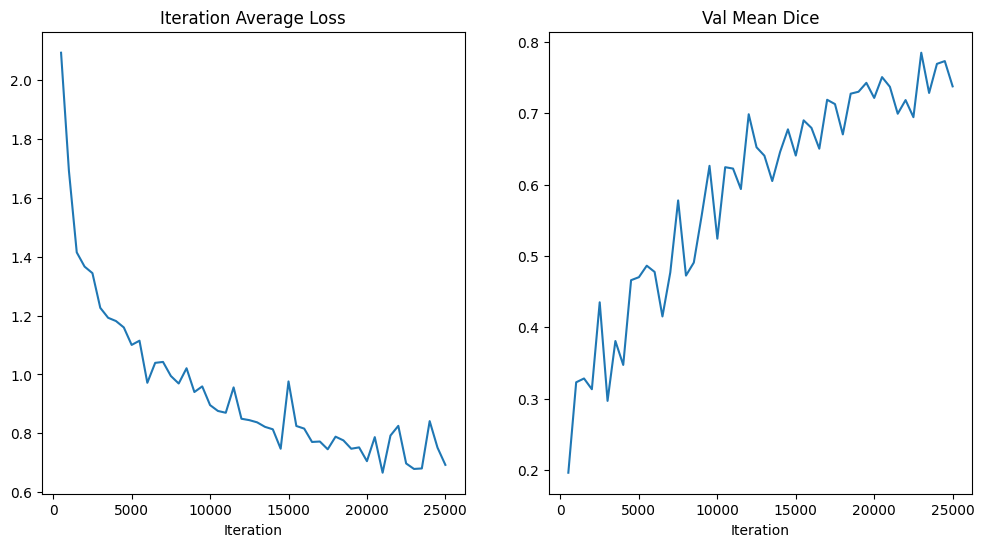

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 2
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset13/"
split_json = "dataset_2.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_onmiccai13_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=3.46573): 100%|█| 24/24 [00:14<00:00,  1.70it/
Training (47 / 25000 Steps) (loss=3.28225): 100%|█| 24/24 [00:12<00:00,  1.98it/
Training (71 / 25000 Steps) (loss=3.13244): 100%|█| 24/24 [00:12<00:00,  1.98it/
Training (95 / 25000 Steps) (loss=3.10949): 100%|█| 24/24 [00:12<00:00,  1.98it/
Training (119 / 25000 Steps) (loss=3.10010): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (143 / 25000 Steps) (loss=3.15406): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (167 / 25000 Steps) (loss=3.03881): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (191 / 25000 Steps) (loss=3.04156): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (215 / 25000 Steps) (loss=2.92104): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (239 / 25000 Steps) (loss=2.97540): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (263 / 25000 Steps) (loss=2.93518): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (287 / 25000 Steps) (loss=2.76930): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.23765355348587036 Current Avg. Dice: 0.23765355348587036


Training (503 / 25000 Steps) (loss=2.53943): 100%|█| 24/24 [00:16<00:00,  1.45it
Training (527 / 25000 Steps) (loss=2.66759): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (551 / 25000 Steps) (loss=2.42921): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (575 / 25000 Steps) (loss=2.37660): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (599 / 25000 Steps) (loss=2.49753): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (623 / 25000 Steps) (loss=2.31966): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (647 / 25000 Steps) (loss=2.25439): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (671 / 25000 Steps) (loss=2.27102): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (695 / 25000 Steps) (loss=2.31263): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (719 / 25000 Steps) (loss=2.21722): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (743 / 25000 Steps) (loss=2.07862): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (767 / 25000 Steps) (loss=2.20508): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.2690102458000183 Current Avg. Dice: 0.2690102458000183


Training (1007 / 25000 Steps) (loss=2.06557): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (1031 / 25000 Steps) (loss=2.14663): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1055 / 25000 Steps) (loss=1.87579): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1079 / 25000 Steps) (loss=1.86896): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1103 / 25000 Steps) (loss=2.02671): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1127 / 25000 Steps) (loss=1.77876): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1151 / 25000 Steps) (loss=1.84658): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1175 / 25000 Steps) (loss=1.97282): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1199 / 25000 Steps) (loss=1.72606): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1223 / 25000 Steps) (loss=1.73707): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1247 / 25000 Steps) (loss=1.74389): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1271 / 25000 Steps) (loss=1.87779): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.2690102458000183 Current Avg. Dice: 0.23849570751190186


Training (1511 / 25000 Steps) (loss=1.59556): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (1535 / 25000 Steps) (loss=1.47398): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1559 / 25000 Steps) (loss=1.67227): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1583 / 25000 Steps) (loss=1.53646): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1607 / 25000 Steps) (loss=1.46784): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1631 / 25000 Steps) (loss=1.60528): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1655 / 25000 Steps) (loss=1.60069): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1679 / 25000 Steps) (loss=1.37845): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1703 / 25000 Steps) (loss=1.57937): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1727 / 25000 Steps) (loss=1.62634): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1751 / 25000 Steps) (loss=1.62084): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1775 / 25000 Steps) (loss=1.49155): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.34684625267982483 Current Avg. Dice: 0.34684625267982483


Training (2015 / 25000 Steps) (loss=1.34884): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (2039 / 25000 Steps) (loss=1.43720): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2063 / 25000 Steps) (loss=1.28025): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2087 / 25000 Steps) (loss=1.57400): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2111 / 25000 Steps) (loss=1.49991): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2135 / 25000 Steps) (loss=1.60133): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2159 / 25000 Steps) (loss=1.28083): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2183 / 25000 Steps) (loss=1.38551): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2207 / 25000 Steps) (loss=1.32383): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2231 / 25000 Steps) (loss=1.58737): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2255 / 25000 Steps) (loss=1.27987): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2279 / 25000 Steps) (loss=1.21003): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.34684625267982483 Current Avg. Dice: 0.33862555027008057


Training (2519 / 25000 Steps) (loss=1.29368): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (2543 / 25000 Steps) (loss=1.41030): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2567 / 25000 Steps) (loss=1.33491): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2591 / 25000 Steps) (loss=1.23867): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2615 / 25000 Steps) (loss=1.42496): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2639 / 25000 Steps) (loss=1.27221): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2663 / 25000 Steps) (loss=1.38130): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2687 / 25000 Steps) (loss=1.41024): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2711 / 25000 Steps) (loss=1.32248): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2735 / 25000 Steps) (loss=1.29444): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2759 / 25000 Steps) (loss=1.30422): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2783 / 25000 Steps) (loss=1.62435): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.34684625267982483 Current Avg. Dice: 0.3453628718852997


Training (3023 / 25000 Steps) (loss=1.34184): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (3047 / 25000 Steps) (loss=1.41216): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3071 / 25000 Steps) (loss=1.15291): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3095 / 25000 Steps) (loss=1.17189): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3119 / 25000 Steps) (loss=1.20119): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3143 / 25000 Steps) (loss=1.27868): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3167 / 25000 Steps) (loss=1.25681): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3191 / 25000 Steps) (loss=1.19392): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3215 / 25000 Steps) (loss=1.30675): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3239 / 25000 Steps) (loss=1.27631): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3263 / 25000 Steps) (loss=1.15973): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3287 / 25000 Steps) (loss=1.32751): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.34684625267982483 Current Avg. Dice: 0.2867726981639862


Training (3503 / 25000 Steps) (loss=1.23928): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (3527 / 25000 Steps) (loss=1.25305): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3551 / 25000 Steps) (loss=1.10473): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3575 / 25000 Steps) (loss=1.36878): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3599 / 25000 Steps) (loss=1.25898): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3623 / 25000 Steps) (loss=1.09948): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3647 / 25000 Steps) (loss=1.03870): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3671 / 25000 Steps) (loss=1.22984): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3695 / 25000 Steps) (loss=1.32220): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3719 / 25000 Steps) (loss=1.33937): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3743 / 25000 Steps) (loss=1.43029): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3767 / 25000 Steps) (loss=1.38125): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.34684625267982483 Current Avg. Dice: 0.2989417016506195


Training (4007 / 25000 Steps) (loss=1.06016): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (4031 / 25000 Steps) (loss=1.21859): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4055 / 25000 Steps) (loss=1.17407): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4079 / 25000 Steps) (loss=1.17739): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4103 / 25000 Steps) (loss=1.18545): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4127 / 25000 Steps) (loss=1.20129): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4151 / 25000 Steps) (loss=1.32267): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4175 / 25000 Steps) (loss=1.11501): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4199 / 25000 Steps) (loss=1.07036): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4223 / 25000 Steps) (loss=1.09527): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4247 / 25000 Steps) (loss=1.55388): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4271 / 25000 Steps) (loss=1.10899): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.37121281027793884 Current Avg. Dice: 0.37121281027793884


Training (4511 / 25000 Steps) (loss=1.20010): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (4535 / 25000 Steps) (loss=1.05447): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4559 / 25000 Steps) (loss=1.21978): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4583 / 25000 Steps) (loss=1.11360): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4607 / 25000 Steps) (loss=1.19866): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4631 / 25000 Steps) (loss=1.17337): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4655 / 25000 Steps) (loss=1.07489): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4679 / 25000 Steps) (loss=1.13769): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4703 / 25000 Steps) (loss=1.16925): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4727 / 25000 Steps) (loss=1.22108): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4751 / 25000 Steps) (loss=1.65078): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4775 / 25000 Steps) (loss=1.21201): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4391654431819916 Current Avg. Dice: 0.4391654431819916


Training (5015 / 25000 Steps) (loss=1.22474): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (5039 / 25000 Steps) (loss=1.20729): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5063 / 25000 Steps) (loss=1.13695): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5087 / 25000 Steps) (loss=1.28099): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5111 / 25000 Steps) (loss=1.18049): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5135 / 25000 Steps) (loss=1.27356): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5159 / 25000 Steps) (loss=1.11765): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5183 / 25000 Steps) (loss=1.09147): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5207 / 25000 Steps) (loss=1.46568): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5231 / 25000 Steps) (loss=1.25828): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5255 / 25000 Steps) (loss=1.04976): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5279 / 25000 Steps) (loss=1.12901): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4391654431819916 Current Avg. Dice: 0.40012040734291077


Training (5519 / 25000 Steps) (loss=1.08555): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (5543 / 25000 Steps) (loss=1.13670): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5567 / 25000 Steps) (loss=1.10664): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5591 / 25000 Steps) (loss=1.00902): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5615 / 25000 Steps) (loss=1.06705): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5639 / 25000 Steps) (loss=1.11718): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5663 / 25000 Steps) (loss=1.15809): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5687 / 25000 Steps) (loss=1.20984): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5711 / 25000 Steps) (loss=1.28154): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5735 / 25000 Steps) (loss=1.05548): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5759 / 25000 Steps) (loss=1.19349): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5783 / 25000 Steps) (loss=1.07772): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4391654431819916 Current Avg. Dice: 0.386500746011734


Training (6023 / 25000 Steps) (loss=1.06673): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (6047 / 25000 Steps) (loss=1.01349): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6071 / 25000 Steps) (loss=1.06632): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6095 / 25000 Steps) (loss=1.05004): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6119 / 25000 Steps) (loss=1.11608): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6143 / 25000 Steps) (loss=1.02973): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6167 / 25000 Steps) (loss=1.17365): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6191 / 25000 Steps) (loss=1.16836): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6215 / 25000 Steps) (loss=1.08068): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6239 / 25000 Steps) (loss=1.07645): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6263 / 25000 Steps) (loss=0.96169): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6287 / 25000 Steps) (loss=1.05092): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4785022735595703 Current Avg. Dice: 0.4785022735595703


Training (6503 / 25000 Steps) (loss=1.04312): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (6527 / 25000 Steps) (loss=1.17427): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6551 / 25000 Steps) (loss=1.03100): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6575 / 25000 Steps) (loss=0.99996): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6599 / 25000 Steps) (loss=1.18256): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6623 / 25000 Steps) (loss=1.10235): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6647 / 25000 Steps) (loss=1.06611): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6671 / 25000 Steps) (loss=1.03464): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6695 / 25000 Steps) (loss=0.98112): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6719 / 25000 Steps) (loss=1.02629): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6743 / 25000 Steps) (loss=1.12752): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6767 / 25000 Steps) (loss=1.04345): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5265701413154602 Current Avg. Dice: 0.5265701413154602


Training (7007 / 25000 Steps) (loss=1.09787): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (7031 / 25000 Steps) (loss=1.02285): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7055 / 25000 Steps) (loss=1.16645): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7079 / 25000 Steps) (loss=1.01847): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7103 / 25000 Steps) (loss=1.31501): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7127 / 25000 Steps) (loss=1.09809): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7151 / 25000 Steps) (loss=1.24317): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7175 / 25000 Steps) (loss=1.33553): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7199 / 25000 Steps) (loss=1.00979): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7223 / 25000 Steps) (loss=0.98846): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7247 / 25000 Steps) (loss=1.03546): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7271 / 25000 Steps) (loss=1.05720): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5265701413154602 Current Avg. Dice: 0.41790375113487244


Training (7511 / 25000 Steps) (loss=0.98524): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (7535 / 25000 Steps) (loss=0.95413): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7559 / 25000 Steps) (loss=1.02811): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7583 / 25000 Steps) (loss=0.96892): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7607 / 25000 Steps) (loss=0.96084): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7631 / 25000 Steps) (loss=1.12486): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7655 / 25000 Steps) (loss=0.97633): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7679 / 25000 Steps) (loss=0.93809): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7703 / 25000 Steps) (loss=1.21362): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7727 / 25000 Steps) (loss=0.89760): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7751 / 25000 Steps) (loss=0.99176): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7775 / 25000 Steps) (loss=0.99605): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5409457087516785 Current Avg. Dice: 0.5409457087516785


Training (8015 / 25000 Steps) (loss=0.98502): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (8039 / 25000 Steps) (loss=0.94101): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8063 / 25000 Steps) (loss=0.95549): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8087 / 25000 Steps) (loss=0.97586): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8111 / 25000 Steps) (loss=0.94568): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8135 / 25000 Steps) (loss=1.05991): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8159 / 25000 Steps) (loss=0.93572): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8183 / 25000 Steps) (loss=0.95229): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8207 / 25000 Steps) (loss=0.96342): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8231 / 25000 Steps) (loss=1.08163): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8255 / 25000 Steps) (loss=1.04503): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8279 / 25000 Steps) (loss=1.04146): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5409457087516785 Current Avg. Dice: 0.495368093252182


Training (8519 / 25000 Steps) (loss=0.98306): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (8543 / 25000 Steps) (loss=1.01811): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8567 / 25000 Steps) (loss=0.93434): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8591 / 25000 Steps) (loss=1.25854): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8615 / 25000 Steps) (loss=0.95400): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8639 / 25000 Steps) (loss=0.90562): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8663 / 25000 Steps) (loss=0.91533): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8687 / 25000 Steps) (loss=0.92004): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8711 / 25000 Steps) (loss=0.97421): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8735 / 25000 Steps) (loss=1.03576): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8759 / 25000 Steps) (loss=1.15723): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8783 / 25000 Steps) (loss=0.90546): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5409457087516785 Current Avg. Dice: 0.5144950747489929


Training (9023 / 25000 Steps) (loss=0.89840): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (9047 / 25000 Steps) (loss=1.11135): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9071 / 25000 Steps) (loss=0.91566): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9095 / 25000 Steps) (loss=0.92907): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9119 / 25000 Steps) (loss=0.96672): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9143 / 25000 Steps) (loss=0.93070): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9167 / 25000 Steps) (loss=0.99949): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9191 / 25000 Steps) (loss=0.97894): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9215 / 25000 Steps) (loss=1.06436): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9239 / 25000 Steps) (loss=0.97687): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9263 / 25000 Steps) (loss=0.92295): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9287 / 25000 Steps) (loss=0.84139): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5548505187034607 Current Avg. Dice: 0.5548505187034607


Training (9503 / 25000 Steps) (loss=0.86222): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (9527 / 25000 Steps) (loss=0.90774): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9551 / 25000 Steps) (loss=1.05612): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9575 / 25000 Steps) (loss=0.94174): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9599 / 25000 Steps) (loss=0.98043): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9623 / 25000 Steps) (loss=0.95559): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9647 / 25000 Steps) (loss=0.86057): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9671 / 25000 Steps) (loss=0.87985): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9695 / 25000 Steps) (loss=0.93351): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9719 / 25000 Steps) (loss=1.01390): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9743 / 25000 Steps) (loss=0.92029): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9767 / 25000 Steps) (loss=0.91079): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5548505187034607 Current Avg. Dice: 0.551461398601532


Training (10007 / 25000 Steps) (loss=0.95808): 100%|█| 24/24 [00:13<00:00,  1.78
Training (10031 / 25000 Steps) (loss=0.92403): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10055 / 25000 Steps) (loss=0.79600): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10079 / 25000 Steps) (loss=0.92170): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10103 / 25000 Steps) (loss=0.83926): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10127 / 25000 Steps) (loss=0.89374): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10151 / 25000 Steps) (loss=0.80500): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10175 / 25000 Steps) (loss=0.98900): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10199 / 25000 Steps) (loss=0.98990): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10223 / 25000 Steps) (loss=0.88056): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10247 / 25000 Steps) (loss=0.87978): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10271 / 25000 Steps) (loss=0.78963): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5825895667076111 Current Avg. Dice: 0.5825895667076111


Training (10511 / 25000 Steps) (loss=0.83562): 100%|█| 24/24 [00:16<00:00,  1.41
Training (10535 / 25000 Steps) (loss=0.86012): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10559 / 25000 Steps) (loss=0.89173): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10583 / 25000 Steps) (loss=0.93498): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10607 / 25000 Steps) (loss=0.80007): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10631 / 25000 Steps) (loss=0.92398): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10655 / 25000 Steps) (loss=0.79840): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10679 / 25000 Steps) (loss=0.80798): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10703 / 25000 Steps) (loss=0.83720): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10727 / 25000 Steps) (loss=0.91592): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10751 / 25000 Steps) (loss=0.80746): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10775 / 25000 Steps) (loss=0.89124): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5882525444030762 Current Avg. Dice: 0.5882525444030762


Training (11015 / 25000 Steps) (loss=0.80751): 100%|█| 24/24 [00:16<00:00,  1.42
Training (11039 / 25000 Steps) (loss=0.83753): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11063 / 25000 Steps) (loss=0.80052): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11087 / 25000 Steps) (loss=0.80749): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11111 / 25000 Steps) (loss=0.85227): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11135 / 25000 Steps) (loss=0.80247): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11159 / 25000 Steps) (loss=0.91839): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11183 / 25000 Steps) (loss=0.75251): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11207 / 25000 Steps) (loss=1.08764): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11231 / 25000 Steps) (loss=0.86666): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11255 / 25000 Steps) (loss=0.91733): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11279 / 25000 Steps) (loss=0.99992): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5882525444030762 Current Avg. Dice: 0.5268089175224304


Training (11519 / 25000 Steps) (loss=1.22082): 100%|█| 24/24 [00:13<00:00,  1.77
Training (11543 / 25000 Steps) (loss=0.75689): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11567 / 25000 Steps) (loss=1.39628): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11591 / 25000 Steps) (loss=0.78315): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11615 / 25000 Steps) (loss=0.90916): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11639 / 25000 Steps) (loss=0.80217): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11663 / 25000 Steps) (loss=0.92831): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11687 / 25000 Steps) (loss=0.91360): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11711 / 25000 Steps) (loss=0.82629): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11735 / 25000 Steps) (loss=0.74750): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11759 / 25000 Steps) (loss=0.70798): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11783 / 25000 Steps) (loss=0.78969): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6032584309577942 Current Avg. Dice: 0.6032584309577942


Training (12023 / 25000 Steps) (loss=0.88245): 100%|█| 24/24 [00:17<00:00,  1.39
Training (12047 / 25000 Steps) (loss=0.87591): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12071 / 25000 Steps) (loss=0.88581): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12095 / 25000 Steps) (loss=0.85033): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12119 / 25000 Steps) (loss=0.78818): 100%|█| 24/24 [00:12<00:00,  1.95
Training (12143 / 25000 Steps) (loss=0.78242): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12167 / 25000 Steps) (loss=0.76122): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12191 / 25000 Steps) (loss=0.72746): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12215 / 25000 Steps) (loss=0.89359): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12239 / 25000 Steps) (loss=0.90124): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12263 / 25000 Steps) (loss=0.90262): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12287 / 25000 Steps) (loss=0.94344): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6032584309577942 Current Avg. Dice: 0.5862931609153748


Training (12503 / 25000 Steps) (loss=0.76353): 100%|█| 24/24 [00:13<00:00,  1.75
Training (12527 / 25000 Steps) (loss=0.81321): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12551 / 25000 Steps) (loss=0.68684): 100%|█| 24/24 [00:12<00:00,  1.95
Training (12575 / 25000 Steps) (loss=0.85749): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12599 / 25000 Steps) (loss=0.91771): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12623 / 25000 Steps) (loss=0.78579): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12647 / 25000 Steps) (loss=0.76153): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12671 / 25000 Steps) (loss=0.88007): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12695 / 25000 Steps) (loss=0.62399): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12719 / 25000 Steps) (loss=1.15075): 100%|█| 24/24 [00:12<00:00,  1.95
Training (12743 / 25000 Steps) (loss=0.70673): 100%|█| 24/24 [00:12<00:00,  1.95
Training (12767 / 25000 Steps) (loss=0.89166): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6032584309577942 Current Avg. Dice: 0.5757505297660828


Training (13007 / 25000 Steps) (loss=0.89381): 100%|█| 24/24 [00:13<00:00,  1.78
Training (13031 / 25000 Steps) (loss=0.91830): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13055 / 25000 Steps) (loss=0.79522): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13079 / 25000 Steps) (loss=0.83366): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13103 / 25000 Steps) (loss=0.83246): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13127 / 25000 Steps) (loss=0.65362): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13151 / 25000 Steps) (loss=0.77003): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13175 / 25000 Steps) (loss=1.27649): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13199 / 25000 Steps) (loss=0.76865): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13223 / 25000 Steps) (loss=0.98234): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13247 / 25000 Steps) (loss=0.73353): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13271 / 25000 Steps) (loss=0.88932): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6032584309577942 Current Avg. Dice: 0.5240349173545837


Training (13511 / 25000 Steps) (loss=0.80167): 100%|█| 24/24 [00:13<00:00,  1.77
Training (13535 / 25000 Steps) (loss=0.86653): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13559 / 25000 Steps) (loss=0.80596): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13583 / 25000 Steps) (loss=0.81427): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13607 / 25000 Steps) (loss=0.90339): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13631 / 25000 Steps) (loss=0.91818): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13655 / 25000 Steps) (loss=0.74901): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13679 / 25000 Steps) (loss=0.85604): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13703 / 25000 Steps) (loss=0.86201): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13727 / 25000 Steps) (loss=0.81423): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13751 / 25000 Steps) (loss=0.89845): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13775 / 25000 Steps) (loss=0.74514): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6032584309577942 Current Avg. Dice: 0.5868377089500427


Training (14015 / 25000 Steps) (loss=0.91616): 100%|█| 24/24 [00:13<00:00,  1.77
Training (14039 / 25000 Steps) (loss=0.81609): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14063 / 25000 Steps) (loss=0.82653): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14087 / 25000 Steps) (loss=0.91995): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14111 / 25000 Steps) (loss=0.72854): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14135 / 25000 Steps) (loss=0.80085): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14159 / 25000 Steps) (loss=0.83452): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14183 / 25000 Steps) (loss=0.88592): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14207 / 25000 Steps) (loss=0.89469): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14231 / 25000 Steps) (loss=0.88003): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14255 / 25000 Steps) (loss=0.79473): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14279 / 25000 Steps) (loss=0.76745): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6032584309577942 Current Avg. Dice: 0.5994334816932678


Training (14519 / 25000 Steps) (loss=0.76807): 100%|█| 24/24 [00:13<00:00,  1.73
Training (14543 / 25000 Steps) (loss=0.79019): 100%|█| 24/24 [00:12<00:00,  1.94
Training (14567 / 25000 Steps) (loss=0.82879): 100%|█| 24/24 [00:12<00:00,  1.94
Training (14591 / 25000 Steps) (loss=0.67221): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14615 / 25000 Steps) (loss=0.91696): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14639 / 25000 Steps) (loss=0.65213): 100%|█| 24/24 [00:12<00:00,  1.95
Training (14663 / 25000 Steps) (loss=0.87926): 100%|█| 24/24 [00:12<00:00,  1.95
Training (14687 / 25000 Steps) (loss=0.90095): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14711 / 25000 Steps) (loss=0.97961): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14735 / 25000 Steps) (loss=0.67286): 100%|█| 24/24 [00:12<00:00,  1.95
Training (14759 / 25000 Steps) (loss=0.63301): 100%|█| 24/24 [00:12<00:00,  1.92
Training (14783 / 25000 Steps) (loss=0.91746): 100%|█| 24/24 [00:12<00:00,  1.94
Training (14807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6106317043304443 Current Avg. Dice: 0.6106317043304443


Training (15023 / 25000 Steps) (loss=0.68930): 100%|█| 24/24 [00:17<00:00,  1.39
Training (15047 / 25000 Steps) (loss=0.83198): 100%|█| 24/24 [00:12<00:00,  1.95
Training (15071 / 25000 Steps) (loss=0.80178): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15095 / 25000 Steps) (loss=1.01306): 100%|█| 24/24 [00:12<00:00,  1.94
Training (15119 / 25000 Steps) (loss=0.87542): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15143 / 25000 Steps) (loss=0.86254): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15167 / 25000 Steps) (loss=0.87412): 100%|█| 24/24 [00:12<00:00,  1.94
Training (15191 / 25000 Steps) (loss=0.67334): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15215 / 25000 Steps) (loss=0.72598): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15239 / 25000 Steps) (loss=0.77373): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15263 / 25000 Steps) (loss=0.82535): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15287 / 25000 Steps) (loss=0.76556): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6106317043304443 Current Avg. Dice: 0.609973669052124


Training (15503 / 25000 Steps) (loss=0.70697): 100%|█| 24/24 [00:13<00:00,  1.76
Training (15527 / 25000 Steps) (loss=0.87371): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15551 / 25000 Steps) (loss=0.60749): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15575 / 25000 Steps) (loss=0.97628): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15599 / 25000 Steps) (loss=0.75079): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15623 / 25000 Steps) (loss=0.67329): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15647 / 25000 Steps) (loss=0.87730): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15671 / 25000 Steps) (loss=0.88002): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15695 / 25000 Steps) (loss=1.06312): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15719 / 25000 Steps) (loss=0.87352): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15743 / 25000 Steps) (loss=0.80904): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15767 / 25000 Steps) (loss=0.76324): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.641176164150238 Current Avg. Dice: 0.641176164150238


Training (16007 / 25000 Steps) (loss=0.70895): 100%|█| 24/24 [00:16<00:00,  1.42
Training (16031 / 25000 Steps) (loss=0.80599): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16055 / 25000 Steps) (loss=0.86579): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16079 / 25000 Steps) (loss=0.93469): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16103 / 25000 Steps) (loss=0.85744): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16127 / 25000 Steps) (loss=0.93838): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16151 / 25000 Steps) (loss=0.77420): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16175 / 25000 Steps) (loss=0.83581): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16199 / 25000 Steps) (loss=0.69761): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16223 / 25000 Steps) (loss=0.88253): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16247 / 25000 Steps) (loss=0.71312): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16271 / 25000 Steps) (loss=0.77377): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.641176164150238 Current Avg. Dice: 0.6210231184959412


Training (16511 / 25000 Steps) (loss=0.70774): 100%|█| 24/24 [00:13<00:00,  1.75
Training (16535 / 25000 Steps) (loss=0.63392): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16559 / 25000 Steps) (loss=0.76099): 100%|█| 24/24 [00:12<00:00,  1.94
Training (16583 / 25000 Steps) (loss=0.73656): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16607 / 25000 Steps) (loss=0.77634): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16631 / 25000 Steps) (loss=0.72151): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16655 / 25000 Steps) (loss=0.72075): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16679 / 25000 Steps) (loss=0.90825): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16703 / 25000 Steps) (loss=0.73485): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16727 / 25000 Steps) (loss=0.83879): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16751 / 25000 Steps) (loss=0.79634): 100%|█| 24/24 [00:12<00:00,  1.94
Training (16775 / 25000 Steps) (loss=0.95256): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.7041030526161194


Training (17015 / 25000 Steps) (loss=0.61850): 100%|█| 24/24 [00:17<00:00,  1.40
Training (17039 / 25000 Steps) (loss=0.86137): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17063 / 25000 Steps) (loss=0.92714): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17087 / 25000 Steps) (loss=0.67967): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17111 / 25000 Steps) (loss=0.75461): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17135 / 25000 Steps) (loss=0.57353): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17159 / 25000 Steps) (loss=0.55813): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17183 / 25000 Steps) (loss=0.86115): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17207 / 25000 Steps) (loss=0.66105): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17231 / 25000 Steps) (loss=0.76295): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17255 / 25000 Steps) (loss=0.66942): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17279 / 25000 Steps) (loss=0.64237): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6139564514160156


Training (17519 / 25000 Steps) (loss=0.82533): 100%|█| 24/24 [00:13<00:00,  1.74
Training (17543 / 25000 Steps) (loss=0.96470): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17567 / 25000 Steps) (loss=0.81053): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17591 / 25000 Steps) (loss=0.72112): 100%|█| 24/24 [00:12<00:00,  1.94
Training (17615 / 25000 Steps) (loss=0.86075): 100%|█| 24/24 [00:12<00:00,  1.95
Training (17639 / 25000 Steps) (loss=0.87782): 100%|█| 24/24 [00:12<00:00,  1.94
Training (17663 / 25000 Steps) (loss=0.74862): 100%|█| 24/24 [00:12<00:00,  1.93
Training (17687 / 25000 Steps) (loss=0.78508): 100%|█| 24/24 [00:12<00:00,  1.91
Training (17711 / 25000 Steps) (loss=0.78774): 100%|█| 24/24 [00:12<00:00,  1.90
Training (17735 / 25000 Steps) (loss=0.67071): 100%|█| 24/24 [00:12<00:00,  1.95
Training (17759 / 25000 Steps) (loss=0.89467): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17783 / 25000 Steps) (loss=0.77724): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6466492414474487


Training (18023 / 25000 Steps) (loss=0.81615): 100%|█| 24/24 [00:13<00:00,  1.77
Training (18047 / 25000 Steps) (loss=0.73780): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18071 / 25000 Steps) (loss=0.74267): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18095 / 25000 Steps) (loss=0.84366): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18119 / 25000 Steps) (loss=0.79520): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18143 / 25000 Steps) (loss=0.69764): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18167 / 25000 Steps) (loss=0.57921): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18191 / 25000 Steps) (loss=0.78784): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18215 / 25000 Steps) (loss=0.86281): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18239 / 25000 Steps) (loss=0.62590): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18263 / 25000 Steps) (loss=0.83353): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18287 / 25000 Steps) (loss=0.75792): 100%|█| 24/24 [00:12<00:00,  1.92
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6534431576728821


Training (18503 / 25000 Steps) (loss=0.87446): 100%|█| 24/24 [00:13<00:00,  1.73
Training (18527 / 25000 Steps) (loss=0.88567): 100%|█| 24/24 [00:12<00:00,  1.95
Training (18551 / 25000 Steps) (loss=1.05274): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18575 / 25000 Steps) (loss=0.69292): 100%|█| 24/24 [00:12<00:00,  1.94
Training (18599 / 25000 Steps) (loss=0.83488): 100%|█| 24/24 [00:12<00:00,  1.94
Training (18623 / 25000 Steps) (loss=0.66633): 100%|█| 24/24 [00:12<00:00,  1.95
Training (18647 / 25000 Steps) (loss=0.68472): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18671 / 25000 Steps) (loss=0.68368): 100%|█| 24/24 [00:12<00:00,  1.93
Training (18695 / 25000 Steps) (loss=0.81882): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18719 / 25000 Steps) (loss=0.55020): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18743 / 25000 Steps) (loss=0.68020): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18767 / 25000 Steps) (loss=0.72522): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.594896137714386


Training (19007 / 25000 Steps) (loss=0.71205): 100%|█| 24/24 [00:13<00:00,  1.76
Training (19031 / 25000 Steps) (loss=0.78228): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19055 / 25000 Steps) (loss=0.61513): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19079 / 25000 Steps) (loss=0.63470): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19103 / 25000 Steps) (loss=0.81901): 100%|█| 24/24 [00:12<00:00,  1.93
Training (19127 / 25000 Steps) (loss=0.72711): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19151 / 25000 Steps) (loss=0.78526): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19175 / 25000 Steps) (loss=0.83789): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19199 / 25000 Steps) (loss=0.84540): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19223 / 25000 Steps) (loss=0.79829): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19247 / 25000 Steps) (loss=0.75166): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19271 / 25000 Steps) (loss=0.67303): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6363735795021057


Training (19511 / 25000 Steps) (loss=0.81421): 100%|█| 24/24 [00:14<00:00,  1.71
Training (19535 / 25000 Steps) (loss=0.67711): 100%|█| 24/24 [00:12<00:00,  1.94
Training (19559 / 25000 Steps) (loss=0.57129): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19583 / 25000 Steps) (loss=0.79266): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19607 / 25000 Steps) (loss=0.87719): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19631 / 25000 Steps) (loss=0.61486): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19655 / 25000 Steps) (loss=0.76742): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19679 / 25000 Steps) (loss=0.61619): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19703 / 25000 Steps) (loss=0.68183): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19727 / 25000 Steps) (loss=0.46226): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19751 / 25000 Steps) (loss=0.82091): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19775 / 25000 Steps) (loss=0.70181): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6837339401245117


Training (20015 / 25000 Steps) (loss=0.61159): 100%|█| 24/24 [00:13<00:00,  1.75
Training (20039 / 25000 Steps) (loss=0.75020): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20063 / 25000 Steps) (loss=0.55100): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20087 / 25000 Steps) (loss=0.68614): 100%|█| 24/24 [00:12<00:00,  1.94
Training (20111 / 25000 Steps) (loss=0.75708): 100%|█| 24/24 [00:12<00:00,  1.95
Training (20135 / 25000 Steps) (loss=0.77343): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20159 / 25000 Steps) (loss=0.64129): 100%|█| 24/24 [00:12<00:00,  1.95
Training (20183 / 25000 Steps) (loss=0.83576): 100%|█| 24/24 [00:12<00:00,  1.93
Training (20207 / 25000 Steps) (loss=0.69316): 100%|█| 24/24 [00:12<00:00,  1.92
Training (20231 / 25000 Steps) (loss=0.79583): 100%|█| 24/24 [00:12<00:00,  1.90
Training (20255 / 25000 Steps) (loss=0.78796): 100%|█| 24/24 [00:12<00:00,  1.91
Training (20279 / 25000 Steps) (loss=0.52988): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6431034207344055


Training (20519 / 25000 Steps) (loss=0.61689): 100%|█| 24/24 [00:13<00:00,  1.73
Training (20543 / 25000 Steps) (loss=0.93141): 100%|█| 24/24 [00:12<00:00,  1.95
Training (20567 / 25000 Steps) (loss=0.77828): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20591 / 25000 Steps) (loss=0.60201): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20615 / 25000 Steps) (loss=0.53376): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20639 / 25000 Steps) (loss=0.86883): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20663 / 25000 Steps) (loss=0.62759): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20687 / 25000 Steps) (loss=0.77147): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20711 / 25000 Steps) (loss=0.82164): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20735 / 25000 Steps) (loss=0.95814): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20759 / 25000 Steps) (loss=0.76233): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20783 / 25000 Steps) (loss=0.81490): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6309177279472351


Training (21023 / 25000 Steps) (loss=0.83499): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21047 / 25000 Steps) (loss=0.74956): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21071 / 25000 Steps) (loss=0.54573): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21095 / 25000 Steps) (loss=0.80158): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21119 / 25000 Steps) (loss=0.56070): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21143 / 25000 Steps) (loss=0.64212): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21167 / 25000 Steps) (loss=0.75229): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21191 / 25000 Steps) (loss=0.84916): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21215 / 25000 Steps) (loss=0.57641): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21239 / 25000 Steps) (loss=0.64961): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21263 / 25000 Steps) (loss=0.76973): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21287 / 25000 Steps) (loss=0.73052): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6352235674858093


Training (21503 / 25000 Steps) (loss=0.61851): 100%|█| 24/24 [00:13<00:00,  1.77
Training (21527 / 25000 Steps) (loss=0.59590): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21551 / 25000 Steps) (loss=0.86331): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21575 / 25000 Steps) (loss=0.72203): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21599 / 25000 Steps) (loss=0.62901): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21623 / 25000 Steps) (loss=0.64923): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21647 / 25000 Steps) (loss=0.59613): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21671 / 25000 Steps) (loss=0.85194): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21695 / 25000 Steps) (loss=0.70917): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21719 / 25000 Steps) (loss=0.71917): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21743 / 25000 Steps) (loss=0.61820): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21767 / 25000 Steps) (loss=0.58365): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6382777094841003


Training (22007 / 25000 Steps) (loss=0.65746): 100%|█| 24/24 [00:13<00:00,  1.76
Training (22031 / 25000 Steps) (loss=0.81815): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22055 / 25000 Steps) (loss=0.65302): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22079 / 25000 Steps) (loss=0.78381): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22103 / 25000 Steps) (loss=0.68983): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22127 / 25000 Steps) (loss=0.77279): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22151 / 25000 Steps) (loss=0.74901): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22175 / 25000 Steps) (loss=0.65673): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22199 / 25000 Steps) (loss=0.85916): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22223 / 25000 Steps) (loss=0.70372): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22247 / 25000 Steps) (loss=0.62711): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22271 / 25000 Steps) (loss=0.82285): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6700320243835449


Training (22511 / 25000 Steps) (loss=0.60105): 100%|█| 24/24 [00:13<00:00,  1.75
Training (22535 / 25000 Steps) (loss=0.75038): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22559 / 25000 Steps) (loss=0.88321): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22583 / 25000 Steps) (loss=0.75703): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22607 / 25000 Steps) (loss=0.63012): 100%|█| 24/24 [00:12<00:00,  1.95
Training (22631 / 25000 Steps) (loss=0.92229): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22655 / 25000 Steps) (loss=0.62430): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22679 / 25000 Steps) (loss=0.63171): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22703 / 25000 Steps) (loss=0.93936): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22727 / 25000 Steps) (loss=0.67427): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22751 / 25000 Steps) (loss=0.54786): 100%|█| 24/24 [00:12<00:00,  1.95
Training (22775 / 25000 Steps) (loss=0.79202): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6493310928344727


Training (23015 / 25000 Steps) (loss=0.69459): 100%|█| 24/24 [00:13<00:00,  1.76
Training (23039 / 25000 Steps) (loss=0.61764): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23063 / 25000 Steps) (loss=0.85602): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23087 / 25000 Steps) (loss=0.55702): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23111 / 25000 Steps) (loss=0.80827): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23135 / 25000 Steps) (loss=0.72842): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23159 / 25000 Steps) (loss=0.61742): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23183 / 25000 Steps) (loss=0.87707): 100%|█| 24/24 [00:12<00:00,  1.95
Training (23207 / 25000 Steps) (loss=0.73422): 100%|█| 24/24 [00:12<00:00,  1.89
Training (23231 / 25000 Steps) (loss=0.60260): 100%|█| 24/24 [00:12<00:00,  1.93
Training (23255 / 25000 Steps) (loss=0.66941): 100%|█| 24/24 [00:12<00:00,  1.93
Training (23279 / 25000 Steps) (loss=0.63531): 100%|█| 24/24 [00:12<00:00,  1.94
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.663557767868042


Training (23519 / 25000 Steps) (loss=0.66165): 100%|█| 24/24 [00:13<00:00,  1.73
Training (23543 / 25000 Steps) (loss=1.04547): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23567 / 25000 Steps) (loss=0.72721): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23591 / 25000 Steps) (loss=0.65357): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23615 / 25000 Steps) (loss=0.77290): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23639 / 25000 Steps) (loss=0.77539): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23663 / 25000 Steps) (loss=0.65174): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23687 / 25000 Steps) (loss=0.69476): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23711 / 25000 Steps) (loss=0.85808): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23735 / 25000 Steps) (loss=0.72743): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23759 / 25000 Steps) (loss=0.78496): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23783 / 25000 Steps) (loss=0.57788): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6449732184410095


Training (24023 / 25000 Steps) (loss=0.72354): 100%|█| 24/24 [00:13<00:00,  1.75
Training (24047 / 25000 Steps) (loss=0.75638): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24071 / 25000 Steps) (loss=0.64664): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24095 / 25000 Steps) (loss=0.67337): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24119 / 25000 Steps) (loss=0.82595): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24143 / 25000 Steps) (loss=0.63301): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24167 / 25000 Steps) (loss=0.65384): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24191 / 25000 Steps) (loss=0.77038): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24215 / 25000 Steps) (loss=0.49371): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24239 / 25000 Steps) (loss=0.79423): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24263 / 25000 Steps) (loss=0.82984): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24287 / 25000 Steps) (loss=0.74954): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6401131749153137


Training (24503 / 25000 Steps) (loss=0.98716): 100%|█| 24/24 [00:13<00:00,  1.75
Training (24527 / 25000 Steps) (loss=0.69253): 100%|█| 24/24 [00:12<00:00,  1.93
Training (24551 / 25000 Steps) (loss=0.79247): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24575 / 25000 Steps) (loss=0.63255): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24599 / 25000 Steps) (loss=0.67126): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24623 / 25000 Steps) (loss=0.46776): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24647 / 25000 Steps) (loss=0.92435): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24671 / 25000 Steps) (loss=0.78561): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24695 / 25000 Steps) (loss=0.82479): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24719 / 25000 Steps) (loss=0.60228): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24743 / 25000 Steps) (loss=0.76765): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24767 / 25000 Steps) (loss=0.69307): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041030526161194 Current Avg. Dice: 0.6508798003196716


Training (25007 / 25000 Steps) (loss=0.65418): 100%|█| 24/24 [00:13<00:00,  1.75


In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7041 at iteration: 17000


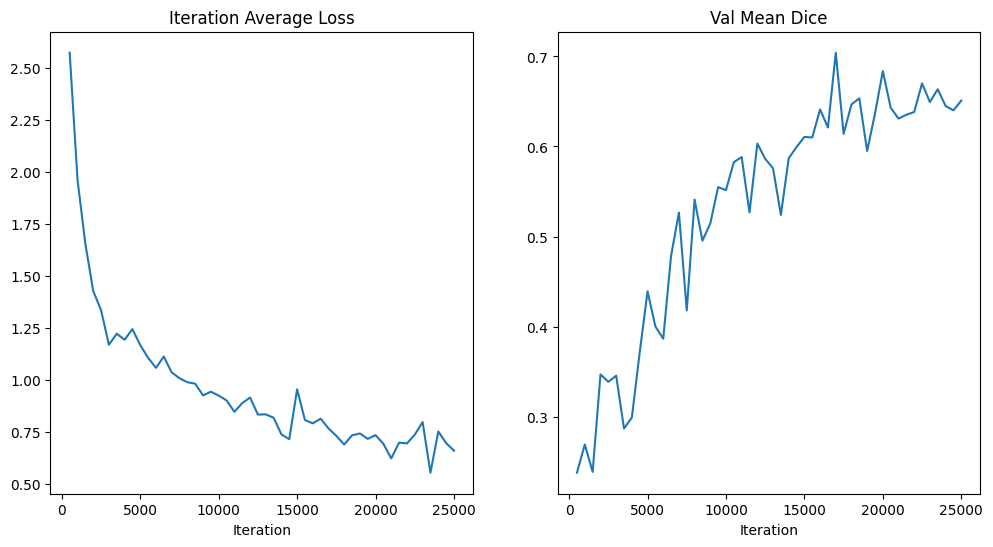

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [14]:
#fold 3
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset13/"
split_json = "dataset_3.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.10it/s]


In [15]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [16]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_onmiccai13_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=3.43693): 100%|█| 24/24 [00:12<00:00,  1.94it/
Training (47 / 25000 Steps) (loss=3.37407): 100%|█| 24/24 [00:12<00:00,  1.96it/
Training (71 / 25000 Steps) (loss=3.24757): 100%|█| 24/24 [00:12<00:00,  1.91it/
Training (95 / 25000 Steps) (loss=3.15517): 100%|█| 24/24 [00:12<00:00,  1.93it/
Training (119 / 25000 Steps) (loss=3.14364): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (143 / 25000 Steps) (loss=3.19773): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (167 / 25000 Steps) (loss=3.00171): 100%|█| 24/24 [00:12<00:00,  1.92it
Training (191 / 25000 Steps) (loss=2.98261): 100%|█| 24/24 [00:12<00:00,  1.93it
Training (215 / 25000 Steps) (loss=3.04590): 100%|█| 24/24 [00:12<00:00,  1.92it
Training (239 / 25000 Steps) (loss=2.86576): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (263 / 25000 Steps) (loss=2.97876): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (287 / 25000 Steps) (loss=2.86314): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.29161325097084045 Current Avg. Dice: 0.29161325097084045


Training (503 / 25000 Steps) (loss=2.53114): 100%|█| 24/24 [00:17<00:00,  1.41it
Training (527 / 25000 Steps) (loss=2.50450): 100%|█| 24/24 [00:12<00:00,  1.90it
Training (551 / 25000 Steps) (loss=2.48478): 100%|█| 24/24 [00:12<00:00,  1.92it
Training (575 / 25000 Steps) (loss=2.52557): 100%|█| 24/24 [00:12<00:00,  1.92it
Training (599 / 25000 Steps) (loss=2.42347): 100%|█| 24/24 [00:12<00:00,  1.90it
Training (623 / 25000 Steps) (loss=2.37699): 100%|█| 24/24 [00:12<00:00,  1.93it
Training (647 / 25000 Steps) (loss=2.32668): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (671 / 25000 Steps) (loss=2.33478): 100%|█| 24/24 [00:12<00:00,  1.93it
Training (695 / 25000 Steps) (loss=2.27966): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (719 / 25000 Steps) (loss=2.27753): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (743 / 25000 Steps) (loss=2.14456): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (767 / 25000 Steps) (loss=2.11375): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.29161325097084045 Current Avg. Dice: 0.2674217224121094


Training (1007 / 25000 Steps) (loss=2.02595): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (1031 / 25000 Steps) (loss=2.01707): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1055 / 25000 Steps) (loss=1.94865): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1079 / 25000 Steps) (loss=1.87350): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1103 / 25000 Steps) (loss=1.86124): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1127 / 25000 Steps) (loss=1.80303): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1151 / 25000 Steps) (loss=1.81090): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1175 / 25000 Steps) (loss=1.84554): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1199 / 25000 Steps) (loss=1.77502): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1223 / 25000 Steps) (loss=1.70758): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1247 / 25000 Steps) (loss=1.73790): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1271 / 25000 Steps) (loss=1.63877): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3081309497356415 Current Avg. Dice: 0.3081309497356415


Training (1511 / 25000 Steps) (loss=1.62682): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (1535 / 25000 Steps) (loss=1.54155): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1559 / 25000 Steps) (loss=1.55666): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1583 / 25000 Steps) (loss=1.66744): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1607 / 25000 Steps) (loss=1.56416): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1631 / 25000 Steps) (loss=1.56848): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1655 / 25000 Steps) (loss=1.54923): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1679 / 25000 Steps) (loss=1.52233): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1703 / 25000 Steps) (loss=1.53507): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1727 / 25000 Steps) (loss=1.56631): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1751 / 25000 Steps) (loss=1.48471): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1775 / 25000 Steps) (loss=1.48814): 100%|█| 24/24 [00:12<00:00,  1.93i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.3081309497356415 Current Avg. Dice: 0.27240991592407227


Training (2015 / 25000 Steps) (loss=1.38912): 100%|█| 24/24 [00:13<00:00,  1.72i
Training (2039 / 25000 Steps) (loss=1.34461): 100%|█| 24/24 [00:12<00:00,  1.93i
Training (2063 / 25000 Steps) (loss=1.29068): 100%|█| 24/24 [00:12<00:00,  1.93i
Training (2087 / 25000 Steps) (loss=1.48567): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (2111 / 25000 Steps) (loss=1.45282): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2135 / 25000 Steps) (loss=1.32792): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2159 / 25000 Steps) (loss=1.39106): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2183 / 25000 Steps) (loss=1.37171): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2207 / 25000 Steps) (loss=1.37311): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2231 / 25000 Steps) (loss=1.33834): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2255 / 25000 Steps) (loss=1.19530): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2279 / 25000 Steps) (loss=1.49275): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.33717772364616394 Current Avg. Dice: 0.33717772364616394


Training (2519 / 25000 Steps) (loss=1.26288): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (2543 / 25000 Steps) (loss=1.23491): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2567 / 25000 Steps) (loss=1.49156): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2591 / 25000 Steps) (loss=1.29579): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2615 / 25000 Steps) (loss=1.33810): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2639 / 25000 Steps) (loss=1.20779): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2663 / 25000 Steps) (loss=1.29117): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2687 / 25000 Steps) (loss=1.26929): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2711 / 25000 Steps) (loss=1.40003): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2735 / 25000 Steps) (loss=1.37524): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2759 / 25000 Steps) (loss=1.31439): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2783 / 25000 Steps) (loss=1.24616): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3513766825199127 Current Avg. Dice: 0.3513766825199127


Training (3023 / 25000 Steps) (loss=1.21028): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (3047 / 25000 Steps) (loss=1.33599): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3071 / 25000 Steps) (loss=1.56434): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3095 / 25000 Steps) (loss=1.13613): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3119 / 25000 Steps) (loss=1.17900): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3143 / 25000 Steps) (loss=1.31727): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3167 / 25000 Steps) (loss=1.24716): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3191 / 25000 Steps) (loss=1.16607): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3215 / 25000 Steps) (loss=1.22084): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3239 / 25000 Steps) (loss=1.17237): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3263 / 25000 Steps) (loss=1.33525): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3287 / 25000 Steps) (loss=1.29203): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.413581520318985 Current Avg. Dice: 0.413581520318985


Training (3503 / 25000 Steps) (loss=1.26969): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (3527 / 25000 Steps) (loss=1.17870): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3551 / 25000 Steps) (loss=1.37844): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3575 / 25000 Steps) (loss=1.34226): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3599 / 25000 Steps) (loss=1.23015): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3623 / 25000 Steps) (loss=1.19813): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3647 / 25000 Steps) (loss=1.20903): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3671 / 25000 Steps) (loss=1.10171): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3695 / 25000 Steps) (loss=1.30544): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3719 / 25000 Steps) (loss=1.16479): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (3743 / 25000 Steps) (loss=1.37532): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3767 / 25000 Steps) (loss=1.22450): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.413581520318985 Current Avg. Dice: 0.4130307137966156


Training (4007 / 25000 Steps) (loss=1.10494): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (4031 / 25000 Steps) (loss=1.14666): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4055 / 25000 Steps) (loss=1.09228): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4079 / 25000 Steps) (loss=1.09332): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4103 / 25000 Steps) (loss=1.09984): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4127 / 25000 Steps) (loss=1.20724): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4151 / 25000 Steps) (loss=1.30081): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4175 / 25000 Steps) (loss=1.16431): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4199 / 25000 Steps) (loss=1.16187): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4223 / 25000 Steps) (loss=1.05585): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4247 / 25000 Steps) (loss=1.10189): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4271 / 25000 Steps) (loss=1.08589): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4321611821651459 Current Avg. Dice: 0.4321611821651459


Training (4511 / 25000 Steps) (loss=1.17267): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (4535 / 25000 Steps) (loss=1.22093): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4559 / 25000 Steps) (loss=1.01392): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4583 / 25000 Steps) (loss=1.13331): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4607 / 25000 Steps) (loss=1.16563): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4631 / 25000 Steps) (loss=1.08854): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4655 / 25000 Steps) (loss=1.08560): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4679 / 25000 Steps) (loss=1.09734): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4703 / 25000 Steps) (loss=1.13241): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (4727 / 25000 Steps) (loss=1.18802): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4751 / 25000 Steps) (loss=1.17279): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4775 / 25000 Steps) (loss=0.99161): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4321611821651459 Current Avg. Dice: 0.3662695586681366


Training (5015 / 25000 Steps) (loss=1.18128): 100%|█| 24/24 [00:13<00:00,  1.74i
Training (5039 / 25000 Steps) (loss=1.20687): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5063 / 25000 Steps) (loss=1.25311): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5087 / 25000 Steps) (loss=1.15444): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5111 / 25000 Steps) (loss=1.16345): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5135 / 25000 Steps) (loss=1.17644): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5159 / 25000 Steps) (loss=1.09300): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5183 / 25000 Steps) (loss=1.02142): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5207 / 25000 Steps) (loss=1.09272): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5231 / 25000 Steps) (loss=1.06317): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5255 / 25000 Steps) (loss=1.00732): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5279 / 25000 Steps) (loss=1.06199): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4321611821651459 Current Avg. Dice: 0.3880324363708496


Training (5519 / 25000 Steps) (loss=1.11081): 100%|█| 24/24 [00:13<00:00,  1.74i
Training (5543 / 25000 Steps) (loss=1.12795): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5567 / 25000 Steps) (loss=1.11182): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5591 / 25000 Steps) (loss=1.08109): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5615 / 25000 Steps) (loss=0.99410): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5639 / 25000 Steps) (loss=1.10474): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5663 / 25000 Steps) (loss=0.95112): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5687 / 25000 Steps) (loss=1.17335): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5711 / 25000 Steps) (loss=1.13910): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5735 / 25000 Steps) (loss=1.09240): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5759 / 25000 Steps) (loss=1.10641): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5783 / 25000 Steps) (loss=1.01918): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4321611821651459 Current Avg. Dice: 0.40010547637939453


Training (6023 / 25000 Steps) (loss=1.05875): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (6047 / 25000 Steps) (loss=1.09600): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6071 / 25000 Steps) (loss=0.99849): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6095 / 25000 Steps) (loss=1.04247): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6119 / 25000 Steps) (loss=1.07118): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6143 / 25000 Steps) (loss=1.06522): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6167 / 25000 Steps) (loss=0.97568): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6191 / 25000 Steps) (loss=0.99905): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6215 / 25000 Steps) (loss=1.09445): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6239 / 25000 Steps) (loss=1.16140): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6263 / 25000 Steps) (loss=1.08236): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6287 / 25000 Steps) (loss=1.03029): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4616425335407257 Current Avg. Dice: 0.4616425335407257


Training (6503 / 25000 Steps) (loss=1.01849): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (6527 / 25000 Steps) (loss=1.11664): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6551 / 25000 Steps) (loss=0.95633): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6575 / 25000 Steps) (loss=0.95852): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6599 / 25000 Steps) (loss=0.99144): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6623 / 25000 Steps) (loss=0.98348): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6647 / 25000 Steps) (loss=1.00587): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6671 / 25000 Steps) (loss=0.99917): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6695 / 25000 Steps) (loss=0.98596): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6719 / 25000 Steps) (loss=1.02117): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6743 / 25000 Steps) (loss=0.97987): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6767 / 25000 Steps) (loss=1.00978): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5266498923301697 Current Avg. Dice: 0.5266498923301697


Training (7007 / 25000 Steps) (loss=1.16048): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (7031 / 25000 Steps) (loss=0.93464): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7055 / 25000 Steps) (loss=1.01048): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7079 / 25000 Steps) (loss=1.02745): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7103 / 25000 Steps) (loss=0.98082): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7127 / 25000 Steps) (loss=0.98974): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7151 / 25000 Steps) (loss=1.03221): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7175 / 25000 Steps) (loss=1.01704): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7199 / 25000 Steps) (loss=1.02816): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7223 / 25000 Steps) (loss=0.99296): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7247 / 25000 Steps) (loss=0.96703): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7271 / 25000 Steps) (loss=0.96334): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5266498923301697 Current Avg. Dice: 0.4350052773952484


Training (7511 / 25000 Steps) (loss=0.99573): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (7535 / 25000 Steps) (loss=0.91611): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7559 / 25000 Steps) (loss=0.97178): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7583 / 25000 Steps) (loss=0.98334): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7607 / 25000 Steps) (loss=1.02247): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7631 / 25000 Steps) (loss=0.94615): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7655 / 25000 Steps) (loss=0.93701): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7679 / 25000 Steps) (loss=1.05706): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7703 / 25000 Steps) (loss=1.18225): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7727 / 25000 Steps) (loss=1.18309): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7751 / 25000 Steps) (loss=0.90549): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7775 / 25000 Steps) (loss=0.96144): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5266498923301697 Current Avg. Dice: 0.4788549244403839


Training (8015 / 25000 Steps) (loss=1.04782): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (8039 / 25000 Steps) (loss=0.96244): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8063 / 25000 Steps) (loss=0.94368): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8087 / 25000 Steps) (loss=0.91261): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8111 / 25000 Steps) (loss=1.00531): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8135 / 25000 Steps) (loss=0.95949): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8159 / 25000 Steps) (loss=1.06139): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8183 / 25000 Steps) (loss=0.89688): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (8207 / 25000 Steps) (loss=0.92703): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8231 / 25000 Steps) (loss=1.03605): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8255 / 25000 Steps) (loss=1.05984): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8279 / 25000 Steps) (loss=1.07405): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5266498923301697 Current Avg. Dice: 0.4990769326686859


Training (8519 / 25000 Steps) (loss=0.96020): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (8543 / 25000 Steps) (loss=1.10121): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8567 / 25000 Steps) (loss=1.00332): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8591 / 25000 Steps) (loss=0.92219): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8615 / 25000 Steps) (loss=0.90692): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8639 / 25000 Steps) (loss=0.98693): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8663 / 25000 Steps) (loss=0.96822): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8687 / 25000 Steps) (loss=0.91916): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8711 / 25000 Steps) (loss=0.88536): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8735 / 25000 Steps) (loss=0.92758): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8759 / 25000 Steps) (loss=1.03153): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8783 / 25000 Steps) (loss=0.94376): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5266498923301697 Current Avg. Dice: 0.46053656935691833


Training (9023 / 25000 Steps) (loss=0.89610): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (9047 / 25000 Steps) (loss=1.04115): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9071 / 25000 Steps) (loss=1.07401): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9095 / 25000 Steps) (loss=0.93780): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9119 / 25000 Steps) (loss=0.93540): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9143 / 25000 Steps) (loss=0.86762): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9167 / 25000 Steps) (loss=0.89200): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9191 / 25000 Steps) (loss=0.96269): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9215 / 25000 Steps) (loss=0.99019): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9239 / 25000 Steps) (loss=1.08412): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9263 / 25000 Steps) (loss=0.98820): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9287 / 25000 Steps) (loss=0.80142): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.558067798614502 Current Avg. Dice: 0.558067798614502


Training (9503 / 25000 Steps) (loss=0.86586): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (9527 / 25000 Steps) (loss=0.90823): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9551 / 25000 Steps) (loss=0.96863): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9575 / 25000 Steps) (loss=0.89105): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9599 / 25000 Steps) (loss=0.98392): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9623 / 25000 Steps) (loss=1.08448): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9647 / 25000 Steps) (loss=0.87793): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9671 / 25000 Steps) (loss=0.91754): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9695 / 25000 Steps) (loss=0.86307): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9719 / 25000 Steps) (loss=0.95855): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9743 / 25000 Steps) (loss=0.89690): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9767 / 25000 Steps) (loss=0.90275): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5729202628135681 Current Avg. Dice: 0.5729202628135681


Training (10007 / 25000 Steps) (loss=0.89223): 100%|█| 24/24 [00:17<00:00,  1.40
Training (10031 / 25000 Steps) (loss=0.89691): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10055 / 25000 Steps) (loss=0.84330): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10079 / 25000 Steps) (loss=0.97736): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10103 / 25000 Steps) (loss=0.81242): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10127 / 25000 Steps) (loss=0.88556): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10151 / 25000 Steps) (loss=0.87986): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10175 / 25000 Steps) (loss=0.90355): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10199 / 25000 Steps) (loss=0.93634): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10223 / 25000 Steps) (loss=0.83071): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10247 / 25000 Steps) (loss=0.99793): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10271 / 25000 Steps) (loss=0.83511): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5737666487693787 Current Avg. Dice: 0.5737666487693787


Training (10511 / 25000 Steps) (loss=0.85555): 100%|█| 24/24 [00:17<00:00,  1.41
Training (10535 / 25000 Steps) (loss=0.89298): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10559 / 25000 Steps) (loss=0.87229): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10583 / 25000 Steps) (loss=0.90386): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10607 / 25000 Steps) (loss=1.00629): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10631 / 25000 Steps) (loss=0.91613): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10655 / 25000 Steps) (loss=0.75652): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10679 / 25000 Steps) (loss=0.83749): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10703 / 25000 Steps) (loss=0.87113): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10727 / 25000 Steps) (loss=0.89202): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10751 / 25000 Steps) (loss=0.84621): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10775 / 25000 Steps) (loss=0.84480): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5737666487693787 Current Avg. Dice: 0.5018767714500427


Training (11015 / 25000 Steps) (loss=0.91037): 100%|█| 24/24 [00:13<00:00,  1.77
Training (11039 / 25000 Steps) (loss=0.81698): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11063 / 25000 Steps) (loss=0.77454): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11087 / 25000 Steps) (loss=0.84857): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11111 / 25000 Steps) (loss=0.88100): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11135 / 25000 Steps) (loss=0.77033): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11159 / 25000 Steps) (loss=0.84132): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11183 / 25000 Steps) (loss=0.84067): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11207 / 25000 Steps) (loss=1.11934): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11231 / 25000 Steps) (loss=0.91124): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11255 / 25000 Steps) (loss=0.94867): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11279 / 25000 Steps) (loss=0.83510): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5737666487693787 Current Avg. Dice: 0.4344986379146576


Training (11519 / 25000 Steps) (loss=0.92327): 100%|█| 24/24 [00:13<00:00,  1.76
Training (11543 / 25000 Steps) (loss=0.87341): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11567 / 25000 Steps) (loss=0.87512): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11591 / 25000 Steps) (loss=0.84488): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11615 / 25000 Steps) (loss=0.89387): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11639 / 25000 Steps) (loss=0.88197): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11663 / 25000 Steps) (loss=1.05265): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11687 / 25000 Steps) (loss=0.92513): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11711 / 25000 Steps) (loss=0.75735): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11735 / 25000 Steps) (loss=0.81577): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11759 / 25000 Steps) (loss=0.79369): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11783 / 25000 Steps) (loss=0.82220): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5737666487693787 Current Avg. Dice: 0.5176391005516052


Training (12023 / 25000 Steps) (loss=0.98372): 100%|█| 24/24 [00:13<00:00,  1.77
Training (12047 / 25000 Steps) (loss=0.80508): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12071 / 25000 Steps) (loss=0.90023): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12095 / 25000 Steps) (loss=0.80671): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12119 / 25000 Steps) (loss=0.94661): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12143 / 25000 Steps) (loss=0.82401): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12167 / 25000 Steps) (loss=0.80015): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12191 / 25000 Steps) (loss=0.80026): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12215 / 25000 Steps) (loss=0.90924): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12239 / 25000 Steps) (loss=0.83233): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12263 / 25000 Steps) (loss=0.83085): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12287 / 25000 Steps) (loss=1.04445): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5737666487693787 Current Avg. Dice: 0.5279573798179626


Training (12503 / 25000 Steps) (loss=0.86592): 100%|█| 24/24 [00:13<00:00,  1.77
Training (12527 / 25000 Steps) (loss=0.77699): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12551 / 25000 Steps) (loss=0.75642): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12575 / 25000 Steps) (loss=0.92706): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12599 / 25000 Steps) (loss=0.89798): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12623 / 25000 Steps) (loss=0.70887): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12647 / 25000 Steps) (loss=0.79754): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12671 / 25000 Steps) (loss=0.75968): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12695 / 25000 Steps) (loss=0.69790): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12719 / 25000 Steps) (loss=0.80077): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12743 / 25000 Steps) (loss=0.79961): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12767 / 25000 Steps) (loss=0.95460): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5737666487693787 Current Avg. Dice: 0.4785771369934082


Training (13007 / 25000 Steps) (loss=0.86942): 100%|█| 24/24 [00:13<00:00,  1.77
Training (13031 / 25000 Steps) (loss=0.87252): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13055 / 25000 Steps) (loss=0.87335): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13079 / 25000 Steps) (loss=0.88809): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13103 / 25000 Steps) (loss=0.86423): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13127 / 25000 Steps) (loss=0.77905): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13151 / 25000 Steps) (loss=0.84783): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13175 / 25000 Steps) (loss=0.84537): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13199 / 25000 Steps) (loss=0.79959): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13223 / 25000 Steps) (loss=0.91781): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13247 / 25000 Steps) (loss=0.85183): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13271 / 25000 Steps) (loss=0.81500): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5737666487693787 Current Avg. Dice: 0.5680760145187378


Training (13511 / 25000 Steps) (loss=0.81809): 100%|█| 24/24 [00:13<00:00,  1.77
Training (13535 / 25000 Steps) (loss=0.87913): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13559 / 25000 Steps) (loss=0.80512): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13583 / 25000 Steps) (loss=0.83379): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13607 / 25000 Steps) (loss=0.85702): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13631 / 25000 Steps) (loss=0.80406): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13655 / 25000 Steps) (loss=0.80667): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13679 / 25000 Steps) (loss=0.83776): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13703 / 25000 Steps) (loss=0.81600): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13727 / 25000 Steps) (loss=0.88111): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13751 / 25000 Steps) (loss=0.80403): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13775 / 25000 Steps) (loss=0.78504): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5737666487693787 Current Avg. Dice: 0.5616894960403442


Training (14015 / 25000 Steps) (loss=0.77490): 100%|█| 24/24 [00:13<00:00,  1.77
Training (14039 / 25000 Steps) (loss=0.87796): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14063 / 25000 Steps) (loss=0.85687): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14087 / 25000 Steps) (loss=0.80798): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14111 / 25000 Steps) (loss=0.73582): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14135 / 25000 Steps) (loss=0.81408): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14159 / 25000 Steps) (loss=0.77061): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14183 / 25000 Steps) (loss=0.90624): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14207 / 25000 Steps) (loss=0.90597): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14231 / 25000 Steps) (loss=0.80622): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14255 / 25000 Steps) (loss=0.77185): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14279 / 25000 Steps) (loss=0.83807): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5940513610839844 Current Avg. Dice: 0.5940513610839844


Training (14519 / 25000 Steps) (loss=0.76212): 100%|█| 24/24 [00:17<00:00,  1.41
Training (14543 / 25000 Steps) (loss=0.94210): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14567 / 25000 Steps) (loss=0.84363): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14591 / 25000 Steps) (loss=0.71011): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14615 / 25000 Steps) (loss=0.77233): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14639 / 25000 Steps) (loss=0.78311): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14663 / 25000 Steps) (loss=0.79513): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14687 / 25000 Steps) (loss=0.84460): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14711 / 25000 Steps) (loss=0.68179): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14735 / 25000 Steps) (loss=0.84722): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14759 / 25000 Steps) (loss=0.90364): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14783 / 25000 Steps) (loss=0.72352): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5940513610839844 Current Avg. Dice: 0.5660471320152283


Training (15023 / 25000 Steps) (loss=0.66116): 100%|█| 24/24 [00:13<00:00,  1.75
Training (15047 / 25000 Steps) (loss=0.75628): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15071 / 25000 Steps) (loss=0.74407): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15095 / 25000 Steps) (loss=0.84415): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15119 / 25000 Steps) (loss=0.81884): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15143 / 25000 Steps) (loss=0.87653): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15167 / 25000 Steps) (loss=0.73249): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15191 / 25000 Steps) (loss=0.64067): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15215 / 25000 Steps) (loss=0.81556): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15239 / 25000 Steps) (loss=0.85309): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15263 / 25000 Steps) (loss=0.84971): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15287 / 25000 Steps) (loss=0.64974): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5940513610839844 Current Avg. Dice: 0.5427003502845764


Training (15503 / 25000 Steps) (loss=0.86784): 100%|█| 24/24 [00:13<00:00,  1.77
Training (15527 / 25000 Steps) (loss=0.66582): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15551 / 25000 Steps) (loss=0.60120): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15575 / 25000 Steps) (loss=0.86066): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15599 / 25000 Steps) (loss=0.76312): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15623 / 25000 Steps) (loss=0.62229): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15647 / 25000 Steps) (loss=0.77316): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15671 / 25000 Steps) (loss=0.79741): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15695 / 25000 Steps) (loss=0.73276): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15719 / 25000 Steps) (loss=0.80883): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15743 / 25000 Steps) (loss=0.76534): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15767 / 25000 Steps) (loss=0.67711): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6019958853721619 Current Avg. Dice: 0.6019958853721619


Training (16007 / 25000 Steps) (loss=0.78814): 100%|█| 24/24 [00:17<00:00,  1.41
Training (16031 / 25000 Steps) (loss=0.82993): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16055 / 25000 Steps) (loss=0.79852): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16079 / 25000 Steps) (loss=0.81365): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16103 / 25000 Steps) (loss=0.70197): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16127 / 25000 Steps) (loss=0.75436): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16151 / 25000 Steps) (loss=0.75907): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16175 / 25000 Steps) (loss=0.82749): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16199 / 25000 Steps) (loss=0.62797): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16223 / 25000 Steps) (loss=0.77061): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16247 / 25000 Steps) (loss=0.63294): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16271 / 25000 Steps) (loss=0.74209): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6019958853721619 Current Avg. Dice: 0.53595370054245


Training (16511 / 25000 Steps) (loss=0.83727): 100%|█| 24/24 [00:13<00:00,  1.77
Training (16535 / 25000 Steps) (loss=0.86026): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16559 / 25000 Steps) (loss=0.77394): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16583 / 25000 Steps) (loss=0.84653): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16607 / 25000 Steps) (loss=1.00442): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16631 / 25000 Steps) (loss=0.72588): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16655 / 25000 Steps) (loss=0.80847): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16679 / 25000 Steps) (loss=0.84555): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16703 / 25000 Steps) (loss=0.74893): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16727 / 25000 Steps) (loss=0.85188): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16751 / 25000 Steps) (loss=0.73542): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16775 / 25000 Steps) (loss=0.75047): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6019958853721619 Current Avg. Dice: 0.5464637875556946


Training (17015 / 25000 Steps) (loss=0.65521): 100%|█| 24/24 [00:13<00:00,  1.77
Training (17039 / 25000 Steps) (loss=0.87152): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17063 / 25000 Steps) (loss=0.67255): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17087 / 25000 Steps) (loss=0.63180): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17111 / 25000 Steps) (loss=0.68144): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17135 / 25000 Steps) (loss=0.83844): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17159 / 25000 Steps) (loss=0.69130): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17183 / 25000 Steps) (loss=0.66844): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17207 / 25000 Steps) (loss=0.71771): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17231 / 25000 Steps) (loss=0.74650): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17255 / 25000 Steps) (loss=0.74431): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17279 / 25000 Steps) (loss=0.76837): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.606692373752594 Current Avg. Dice: 0.606692373752594


Training (17519 / 25000 Steps) (loss=0.96912): 100%|█| 24/24 [00:17<00:00,  1.41
Training (17543 / 25000 Steps) (loss=0.80987): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17567 / 25000 Steps) (loss=0.83617): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17591 / 25000 Steps) (loss=0.64945): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17615 / 25000 Steps) (loss=0.61909): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17639 / 25000 Steps) (loss=0.70893): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17663 / 25000 Steps) (loss=0.68820): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17687 / 25000 Steps) (loss=0.61665): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17711 / 25000 Steps) (loss=0.82868): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17735 / 25000 Steps) (loss=0.61812): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17759 / 25000 Steps) (loss=0.85712): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17783 / 25000 Steps) (loss=0.71568): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6207506060600281 Current Avg. Dice: 0.6207506060600281


Training (18023 / 25000 Steps) (loss=0.71930): 100%|█| 24/24 [00:17<00:00,  1.40
Training (18047 / 25000 Steps) (loss=0.73181): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18071 / 25000 Steps) (loss=0.81705): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18095 / 25000 Steps) (loss=0.82744): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18119 / 25000 Steps) (loss=0.74020): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18143 / 25000 Steps) (loss=0.68265): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18167 / 25000 Steps) (loss=0.73798): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18191 / 25000 Steps) (loss=0.81689): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18215 / 25000 Steps) (loss=0.89022): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18239 / 25000 Steps) (loss=0.65228): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18263 / 25000 Steps) (loss=0.82588): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18287 / 25000 Steps) (loss=0.82701): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6282382607460022 Current Avg. Dice: 0.6282382607460022


Training (18503 / 25000 Steps) (loss=0.73508): 100%|█| 24/24 [00:17<00:00,  1.41
Training (18527 / 25000 Steps) (loss=0.53242): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18551 / 25000 Steps) (loss=0.80894): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18575 / 25000 Steps) (loss=0.62660): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18599 / 25000 Steps) (loss=0.89912): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18623 / 25000 Steps) (loss=0.74599): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18647 / 25000 Steps) (loss=0.58263): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18671 / 25000 Steps) (loss=0.78377): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18695 / 25000 Steps) (loss=0.87201): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18719 / 25000 Steps) (loss=0.51491): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18743 / 25000 Steps) (loss=0.85857): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18767 / 25000 Steps) (loss=0.76081): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6282382607460022 Current Avg. Dice: 0.6104161739349365


Training (19007 / 25000 Steps) (loss=0.70937): 100%|█| 24/24 [00:13<00:00,  1.75
Training (19031 / 25000 Steps) (loss=0.77232): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19055 / 25000 Steps) (loss=0.53839): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19079 / 25000 Steps) (loss=0.82807): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19103 / 25000 Steps) (loss=0.82820): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19127 / 25000 Steps) (loss=0.72420): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19151 / 25000 Steps) (loss=0.68898): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19175 / 25000 Steps) (loss=0.82181): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19199 / 25000 Steps) (loss=0.69217): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19223 / 25000 Steps) (loss=0.78977): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19247 / 25000 Steps) (loss=0.55151): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19271 / 25000 Steps) (loss=0.50868): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6634628772735596 Current Avg. Dice: 0.6634628772735596


Training (19511 / 25000 Steps) (loss=0.81861): 100%|█| 24/24 [00:17<00:00,  1.39
Training (19535 / 25000 Steps) (loss=0.59814): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19559 / 25000 Steps) (loss=0.82706): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19583 / 25000 Steps) (loss=0.79771): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19607 / 25000 Steps) (loss=0.89630): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19631 / 25000 Steps) (loss=0.59357): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19655 / 25000 Steps) (loss=0.71920): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19679 / 25000 Steps) (loss=0.96252): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19703 / 25000 Steps) (loss=0.84854): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19727 / 25000 Steps) (loss=0.66587): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19751 / 25000 Steps) (loss=0.81173): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19775 / 25000 Steps) (loss=0.75147): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6634628772735596 Current Avg. Dice: 0.5901206135749817


Training (20015 / 25000 Steps) (loss=0.59397): 100%|█| 24/24 [00:13<00:00,  1.75
Training (20039 / 25000 Steps) (loss=0.79712): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20063 / 25000 Steps) (loss=0.68964): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20087 / 25000 Steps) (loss=0.65037): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20111 / 25000 Steps) (loss=0.80728): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20135 / 25000 Steps) (loss=0.67514): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20159 / 25000 Steps) (loss=0.80942): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20183 / 25000 Steps) (loss=0.62449): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20207 / 25000 Steps) (loss=0.74155): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20231 / 25000 Steps) (loss=0.65651): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20255 / 25000 Steps) (loss=0.79572): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20279 / 25000 Steps) (loss=0.65203): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6634628772735596 Current Avg. Dice: 0.622471272945404


Training (20519 / 25000 Steps) (loss=0.69371): 100%|█| 24/24 [00:13<00:00,  1.75
Training (20543 / 25000 Steps) (loss=0.67950): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20567 / 25000 Steps) (loss=0.55586): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20591 / 25000 Steps) (loss=0.74280): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20615 / 25000 Steps) (loss=0.53373): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20639 / 25000 Steps) (loss=0.77076): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20663 / 25000 Steps) (loss=1.00291): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20687 / 25000 Steps) (loss=0.62842): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20711 / 25000 Steps) (loss=0.86299): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20735 / 25000 Steps) (loss=0.72770): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20759 / 25000 Steps) (loss=0.70147): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20783 / 25000 Steps) (loss=0.69501): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6909381747245789 Current Avg. Dice: 0.6909381747245789


Training (21023 / 25000 Steps) (loss=0.69082): 100%|█| 24/24 [00:17<00:00,  1.41
Training (21047 / 25000 Steps) (loss=0.74298): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21071 / 25000 Steps) (loss=0.67371): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21095 / 25000 Steps) (loss=0.77270): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21119 / 25000 Steps) (loss=0.54810): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21143 / 25000 Steps) (loss=0.63810): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21167 / 25000 Steps) (loss=0.60681): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21191 / 25000 Steps) (loss=0.80753): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21215 / 25000 Steps) (loss=0.61025): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21239 / 25000 Steps) (loss=0.60309): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21263 / 25000 Steps) (loss=0.71061): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21287 / 25000 Steps) (loss=0.83859): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6909381747245789 Current Avg. Dice: 0.564789354801178


Training (21503 / 25000 Steps) (loss=0.77110): 100%|█| 24/24 [00:13<00:00,  1.77
Training (21527 / 25000 Steps) (loss=0.71787): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21551 / 25000 Steps) (loss=0.73839): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21575 / 25000 Steps) (loss=0.63833): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21599 / 25000 Steps) (loss=0.62121): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21623 / 25000 Steps) (loss=0.67130): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21647 / 25000 Steps) (loss=0.63750): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21671 / 25000 Steps) (loss=0.77339): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21695 / 25000 Steps) (loss=0.74698): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21719 / 25000 Steps) (loss=0.60863): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21743 / 25000 Steps) (loss=0.69503): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21767 / 25000 Steps) (loss=0.78138): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6909381747245789 Current Avg. Dice: 0.6003162264823914


Training (22007 / 25000 Steps) (loss=0.76535): 100%|█| 24/24 [00:13<00:00,  1.75
Training (22031 / 25000 Steps) (loss=0.72668): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22055 / 25000 Steps) (loss=0.85303): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22079 / 25000 Steps) (loss=0.86865): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22103 / 25000 Steps) (loss=0.68891): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22127 / 25000 Steps) (loss=0.68069): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22151 / 25000 Steps) (loss=0.55655): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22175 / 25000 Steps) (loss=0.53866): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22199 / 25000 Steps) (loss=0.77333): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22223 / 25000 Steps) (loss=0.63472): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22247 / 25000 Steps) (loss=0.88435): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22271 / 25000 Steps) (loss=0.60186): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6909381747245789 Current Avg. Dice: 0.648563027381897


Training (22511 / 25000 Steps) (loss=0.38989): 100%|█| 24/24 [00:13<00:00,  1.75
Training (22535 / 25000 Steps) (loss=0.46301): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22559 / 25000 Steps) (loss=0.64401): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22583 / 25000 Steps) (loss=0.59502): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22607 / 25000 Steps) (loss=0.54364): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22631 / 25000 Steps) (loss=0.60647): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22655 / 25000 Steps) (loss=0.70567): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22679 / 25000 Steps) (loss=0.76661): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22703 / 25000 Steps) (loss=0.77926): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22727 / 25000 Steps) (loss=0.74418): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22751 / 25000 Steps) (loss=0.79615): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22775 / 25000 Steps) (loss=0.70316): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6909381747245789 Current Avg. Dice: 0.5755950808525085


Training (23015 / 25000 Steps) (loss=0.69114): 100%|█| 24/24 [00:13<00:00,  1.75
Training (23039 / 25000 Steps) (loss=0.48044): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23063 / 25000 Steps) (loss=0.72274): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23087 / 25000 Steps) (loss=0.46690): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23111 / 25000 Steps) (loss=0.60817): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23135 / 25000 Steps) (loss=0.76270): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23159 / 25000 Steps) (loss=0.60288): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23183 / 25000 Steps) (loss=0.74055): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23207 / 25000 Steps) (loss=0.83158): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23231 / 25000 Steps) (loss=0.51927): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23255 / 25000 Steps) (loss=0.79687): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23279 / 25000 Steps) (loss=0.58907): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6909381747245789 Current Avg. Dice: 0.6814336776733398


Training (23519 / 25000 Steps) (loss=0.68212): 100%|█| 24/24 [00:13<00:00,  1.75
Training (23543 / 25000 Steps) (loss=0.71723): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23567 / 25000 Steps) (loss=0.59838): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23591 / 25000 Steps) (loss=0.70627): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23615 / 25000 Steps) (loss=0.64135): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23639 / 25000 Steps) (loss=0.83355): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23663 / 25000 Steps) (loss=0.65281): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23687 / 25000 Steps) (loss=0.78153): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23711 / 25000 Steps) (loss=0.73175): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23735 / 25000 Steps) (loss=0.58583): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23759 / 25000 Steps) (loss=0.68848): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23783 / 25000 Steps) (loss=0.80733): 100%|█| 24/24 [00:12<00:00,  1.95
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6909381747245789 Current Avg. Dice: 0.6215534210205078


Training (24023 / 25000 Steps) (loss=0.72966): 100%|█| 24/24 [00:13<00:00,  1.75
Training (24047 / 25000 Steps) (loss=0.76951): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24071 / 25000 Steps) (loss=0.65474): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24095 / 25000 Steps) (loss=0.59537): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24119 / 25000 Steps) (loss=0.83610): 100%|█| 24/24 [00:12<00:00,  1.94
Training (24143 / 25000 Steps) (loss=0.51485): 100%|█| 24/24 [00:12<00:00,  1.93
Training (24167 / 25000 Steps) (loss=0.82767): 100%|█| 24/24 [00:12<00:00,  1.94
Training (24191 / 25000 Steps) (loss=0.45205): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24215 / 25000 Steps) (loss=0.66775): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24239 / 25000 Steps) (loss=0.78404): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24263 / 25000 Steps) (loss=0.71855): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24287 / 25000 Steps) (loss=0.56583): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6909381747245789 Current Avg. Dice: 0.6552900671958923


Training (24503 / 25000 Steps) (loss=0.64009): 100%|█| 24/24 [00:13<00:00,  1.75
Training (24527 / 25000 Steps) (loss=0.72076): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24551 / 25000 Steps) (loss=0.74289): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24575 / 25000 Steps) (loss=0.72742): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24599 / 25000 Steps) (loss=0.70247): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24623 / 25000 Steps) (loss=0.76123): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24647 / 25000 Steps) (loss=0.78734): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24671 / 25000 Steps) (loss=0.60158): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24695 / 25000 Steps) (loss=0.71395): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24719 / 25000 Steps) (loss=0.63285): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24743 / 25000 Steps) (loss=0.78249): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24767 / 25000 Steps) (loss=0.73460): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6909381747245789 Current Avg. Dice: 0.6148553490638733


Training (25007 / 25000 Steps) (loss=0.67536): 100%|█| 24/24 [00:13<00:00,  1.75


In [17]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.6909 at iteration: 21000


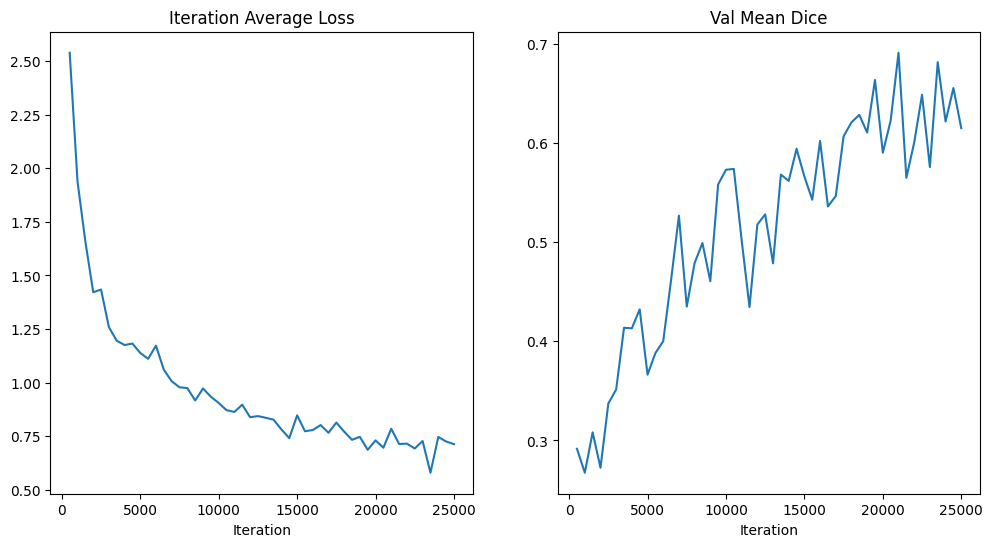

In [18]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 4
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset13/"
split_json = "dataset_4.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.15it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
#         print(x.shape,y.shape)
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_onmiccai13_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold4_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=3.18745): 100%|█| 24/24 [00:14<00:00,  1.69it/
Training (47 / 25000 Steps) (loss=2.93007): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (71 / 25000 Steps) (loss=2.81571): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (95 / 25000 Steps) (loss=2.84946): 100%|█| 24/24 [00:12<00:00,  1.95it/
Training (119 / 25000 Steps) (loss=2.72683): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (143 / 25000 Steps) (loss=2.64093): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (167 / 25000 Steps) (loss=2.56608): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (191 / 25000 Steps) (loss=2.43738): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (215 / 25000 Steps) (loss=2.49193): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (239 / 25000 Steps) (loss=2.41497): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (263 / 25000 Steps) (loss=2.39862): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (287 / 25000 Steps) (loss=2.25384): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.30641672015190125 Current Avg. Dice: 0.30641672015190125


Training (503 / 25000 Steps) (loss=2.05618): 100%|█| 24/24 [00:16<00:00,  1.43it
Training (527 / 25000 Steps) (loss=1.93326): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (551 / 25000 Steps) (loss=2.05053): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (575 / 25000 Steps) (loss=2.01891): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (599 / 25000 Steps) (loss=1.95052): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (623 / 25000 Steps) (loss=1.80447): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (647 / 25000 Steps) (loss=1.91347): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (671 / 25000 Steps) (loss=1.90376): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (695 / 25000 Steps) (loss=1.78519): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (719 / 25000 Steps) (loss=1.84733): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (743 / 25000 Steps) (loss=1.75283): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (767 / 25000 Steps) (loss=1.72664): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.30641672015190125 Current Avg. Dice: 0.22896474599838257


Training (1007 / 25000 Steps) (loss=1.61206): 100%|█| 24/24 [00:13<00:00,  1.73i
Training (1031 / 25000 Steps) (loss=1.67360): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1055 / 25000 Steps) (loss=1.66519): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1079 / 25000 Steps) (loss=1.70303): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1103 / 25000 Steps) (loss=1.67281): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1127 / 25000 Steps) (loss=2.03659): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1151 / 25000 Steps) (loss=1.87703): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1175 / 25000 Steps) (loss=1.63943): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1199 / 25000 Steps) (loss=1.59313): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1223 / 25000 Steps) (loss=1.60544): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1247 / 25000 Steps) (loss=1.37572): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1271 / 25000 Steps) (loss=1.66994): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.310234010219574 Current Avg. Dice: 0.310234010219574


Training (1511 / 25000 Steps) (loss=1.39278): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (1535 / 25000 Steps) (loss=1.37616): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1559 / 25000 Steps) (loss=1.96172): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1583 / 25000 Steps) (loss=1.39383): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1607 / 25000 Steps) (loss=1.38963): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1631 / 25000 Steps) (loss=1.28806): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1655 / 25000 Steps) (loss=1.36544): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1679 / 25000 Steps) (loss=1.39436): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1703 / 25000 Steps) (loss=1.34574): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1727 / 25000 Steps) (loss=1.31940): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1751 / 25000 Steps) (loss=1.35052): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1775 / 25000 Steps) (loss=1.52509): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3760190010070801 Current Avg. Dice: 0.3760190010070801


Training (2015 / 25000 Steps) (loss=1.35129): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (2039 / 25000 Steps) (loss=1.26584): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2063 / 25000 Steps) (loss=1.16746): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2087 / 25000 Steps) (loss=1.30695): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2111 / 25000 Steps) (loss=1.29817): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (2135 / 25000 Steps) (loss=1.46827): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2159 / 25000 Steps) (loss=1.31313): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2183 / 25000 Steps) (loss=1.20222): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2207 / 25000 Steps) (loss=1.36086): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2231 / 25000 Steps) (loss=1.16861): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2255 / 25000 Steps) (loss=1.30275): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2279 / 25000 Steps) (loss=1.58355): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.3760190010070801 Current Avg. Dice: 0.360342413187027


Training (2519 / 25000 Steps) (loss=1.29081): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (2543 / 25000 Steps) (loss=1.18465): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2567 / 25000 Steps) (loss=1.36735): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2591 / 25000 Steps) (loss=1.22740): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2615 / 25000 Steps) (loss=1.21078): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2639 / 25000 Steps) (loss=1.21915): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2663 / 25000 Steps) (loss=1.40212): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2687 / 25000 Steps) (loss=1.26710): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2711 / 25000 Steps) (loss=1.24850): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2735 / 25000 Steps) (loss=1.47306): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2759 / 25000 Steps) (loss=1.19577): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2783 / 25000 Steps) (loss=1.44727): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.3760190010070801 Current Avg. Dice: 0.29084089398384094


Training (3023 / 25000 Steps) (loss=1.16080): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (3047 / 25000 Steps) (loss=1.38579): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3071 / 25000 Steps) (loss=1.20248): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3095 / 25000 Steps) (loss=1.05777): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3119 / 25000 Steps) (loss=1.18448): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3143 / 25000 Steps) (loss=1.26865): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3167 / 25000 Steps) (loss=1.29602): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3191 / 25000 Steps) (loss=1.15977): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3215 / 25000 Steps) (loss=1.13793): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3239 / 25000 Steps) (loss=1.15147): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3263 / 25000 Steps) (loss=1.11004): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3287 / 25000 Steps) (loss=1.19415): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.3760190010070801 Current Avg. Dice: 0.24978239834308624


Training (3503 / 25000 Steps) (loss=1.25537): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (3527 / 25000 Steps) (loss=1.06328): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3551 / 25000 Steps) (loss=1.19610): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3575 / 25000 Steps) (loss=1.21196): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3599 / 25000 Steps) (loss=1.28889): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3623 / 25000 Steps) (loss=1.16613): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3647 / 25000 Steps) (loss=1.13223): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3671 / 25000 Steps) (loss=1.12027): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3695 / 25000 Steps) (loss=1.12163): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3719 / 25000 Steps) (loss=1.08142): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3743 / 25000 Steps) (loss=1.03924): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (3767 / 25000 Steps) (loss=1.13880): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.3760190010070801 Current Avg. Dice: 0.3303956389427185


Training (4007 / 25000 Steps) (loss=1.14156): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (4031 / 25000 Steps) (loss=1.05257): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4055 / 25000 Steps) (loss=1.08071): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4079 / 25000 Steps) (loss=1.20606): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4103 / 25000 Steps) (loss=1.13211): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4127 / 25000 Steps) (loss=1.15807): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4151 / 25000 Steps) (loss=1.14914): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4175 / 25000 Steps) (loss=1.11723): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4199 / 25000 Steps) (loss=0.97904): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4223 / 25000 Steps) (loss=1.06460): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4247 / 25000 Steps) (loss=1.09046): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4271 / 25000 Steps) (loss=1.11138): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.5225010514259338


Training (4511 / 25000 Steps) (loss=1.01907): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (4535 / 25000 Steps) (loss=1.07495): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4559 / 25000 Steps) (loss=1.04936): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4583 / 25000 Steps) (loss=1.07438): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4607 / 25000 Steps) (loss=1.18616): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4631 / 25000 Steps) (loss=1.06239): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4655 / 25000 Steps) (loss=1.00387): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4679 / 25000 Steps) (loss=1.13218): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4703 / 25000 Steps) (loss=1.07788): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4727 / 25000 Steps) (loss=1.01944): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4751 / 25000 Steps) (loss=1.18745): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4775 / 25000 Steps) (loss=1.01305): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.45667457580566406


Training (5015 / 25000 Steps) (loss=1.02309): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (5039 / 25000 Steps) (loss=1.12869): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5063 / 25000 Steps) (loss=1.00235): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5087 / 25000 Steps) (loss=0.92539): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5111 / 25000 Steps) (loss=1.72280): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5135 / 25000 Steps) (loss=0.99953): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5159 / 25000 Steps) (loss=1.13654): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5183 / 25000 Steps) (loss=1.06036): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5207 / 25000 Steps) (loss=1.05286): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5231 / 25000 Steps) (loss=1.07980): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5255 / 25000 Steps) (loss=1.02878): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5279 / 25000 Steps) (loss=1.03471): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.40579065680503845


Training (5519 / 25000 Steps) (loss=1.03682): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (5543 / 25000 Steps) (loss=1.04579): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5567 / 25000 Steps) (loss=1.60682): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5591 / 25000 Steps) (loss=1.23124): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5615 / 25000 Steps) (loss=1.13493): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5639 / 25000 Steps) (loss=1.03302): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5663 / 25000 Steps) (loss=0.98992): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5687 / 25000 Steps) (loss=1.04074): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5711 / 25000 Steps) (loss=1.02486): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5735 / 25000 Steps) (loss=1.00082): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5759 / 25000 Steps) (loss=1.00723): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5783 / 25000 Steps) (loss=0.97224): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.3909655809402466


Training (6023 / 25000 Steps) (loss=1.00993): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (6047 / 25000 Steps) (loss=0.91869): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6071 / 25000 Steps) (loss=1.24422): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6095 / 25000 Steps) (loss=0.96841): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6119 / 25000 Steps) (loss=1.00960): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6143 / 25000 Steps) (loss=1.03251): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6167 / 25000 Steps) (loss=0.98463): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6191 / 25000 Steps) (loss=0.93545): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6215 / 25000 Steps) (loss=0.90666): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6239 / 25000 Steps) (loss=1.02915): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6263 / 25000 Steps) (loss=1.07220): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6287 / 25000 Steps) (loss=0.87355): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.3928106129169464


Training (6503 / 25000 Steps) (loss=1.06096): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (6527 / 25000 Steps) (loss=0.92326): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6551 / 25000 Steps) (loss=1.02952): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6575 / 25000 Steps) (loss=0.95835): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6599 / 25000 Steps) (loss=0.89025): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6623 / 25000 Steps) (loss=0.98402): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6647 / 25000 Steps) (loss=1.03020): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6671 / 25000 Steps) (loss=0.97033): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6695 / 25000 Steps) (loss=0.95247): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6719 / 25000 Steps) (loss=1.12892): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6743 / 25000 Steps) (loss=0.92617): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6767 / 25000 Steps) (loss=1.07017): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.4279421269893646


Training (7007 / 25000 Steps) (loss=0.92926): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (7031 / 25000 Steps) (loss=1.05767): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7055 / 25000 Steps) (loss=0.96215): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7079 / 25000 Steps) (loss=0.95773): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7103 / 25000 Steps) (loss=0.99901): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7127 / 25000 Steps) (loss=0.94163): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7151 / 25000 Steps) (loss=0.92496): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7175 / 25000 Steps) (loss=1.05427): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7199 / 25000 Steps) (loss=0.93085): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7223 / 25000 Steps) (loss=0.91472): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7247 / 25000 Steps) (loss=0.95295): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7271 / 25000 Steps) (loss=0.93801): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.454047292470932


Training (7511 / 25000 Steps) (loss=0.96575): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (7535 / 25000 Steps) (loss=0.95331): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7559 / 25000 Steps) (loss=0.86973): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7583 / 25000 Steps) (loss=0.94400): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7607 / 25000 Steps) (loss=0.94509): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7631 / 25000 Steps) (loss=0.96336): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7655 / 25000 Steps) (loss=1.08127): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7679 / 25000 Steps) (loss=1.08342): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7703 / 25000 Steps) (loss=0.92903): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7727 / 25000 Steps) (loss=0.92920): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7751 / 25000 Steps) (loss=1.29817): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7775 / 25000 Steps) (loss=1.04526): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.397865891456604


Training (8015 / 25000 Steps) (loss=0.86735): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (8039 / 25000 Steps) (loss=0.93009): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8063 / 25000 Steps) (loss=1.01515): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8087 / 25000 Steps) (loss=0.95703): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8111 / 25000 Steps) (loss=1.00449): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8135 / 25000 Steps) (loss=0.89821): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8159 / 25000 Steps) (loss=0.92951): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8183 / 25000 Steps) (loss=0.99885): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8207 / 25000 Steps) (loss=0.92628): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8231 / 25000 Steps) (loss=0.93464): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8255 / 25000 Steps) (loss=1.10439): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8279 / 25000 Steps) (loss=1.01858): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.3936823308467865


Training (8519 / 25000 Steps) (loss=0.96320): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (8543 / 25000 Steps) (loss=0.91986): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8567 / 25000 Steps) (loss=0.98649): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8591 / 25000 Steps) (loss=0.92735): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8615 / 25000 Steps) (loss=0.88330): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8639 / 25000 Steps) (loss=0.89705): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8663 / 25000 Steps) (loss=0.96517): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8687 / 25000 Steps) (loss=0.92495): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8711 / 25000 Steps) (loss=0.92556): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8735 / 25000 Steps) (loss=0.88608): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8759 / 25000 Steps) (loss=1.06541): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8783 / 25000 Steps) (loss=0.88128): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.5217994451522827


Training (9023 / 25000 Steps) (loss=0.99423): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (9047 / 25000 Steps) (loss=0.85591): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9071 / 25000 Steps) (loss=0.91277): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9095 / 25000 Steps) (loss=0.94569): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9119 / 25000 Steps) (loss=1.00571): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9143 / 25000 Steps) (loss=0.90134): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9167 / 25000 Steps) (loss=0.92117): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9191 / 25000 Steps) (loss=0.88045): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9215 / 25000 Steps) (loss=0.93384): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9239 / 25000 Steps) (loss=0.86643): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9263 / 25000 Steps) (loss=0.86868): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9287 / 25000 Steps) (loss=0.89486): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5225010514259338 Current Avg. Dice: 0.4427119791507721


Training (9503 / 25000 Steps) (loss=0.96869): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (9527 / 25000 Steps) (loss=0.88088): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9551 / 25000 Steps) (loss=0.84478): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9575 / 25000 Steps) (loss=0.88273): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9599 / 25000 Steps) (loss=0.99217): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9623 / 25000 Steps) (loss=0.82763): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9647 / 25000 Steps) (loss=0.79088): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9671 / 25000 Steps) (loss=0.79950): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9695 / 25000 Steps) (loss=0.91195): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9719 / 25000 Steps) (loss=0.88720): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9743 / 25000 Steps) (loss=0.84728): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9767 / 25000 Steps) (loss=0.81818): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5789088010787964 Current Avg. Dice: 0.5789088010787964


Training (10007 / 25000 Steps) (loss=0.88265): 100%|█| 24/24 [00:16<00:00,  1.41
Training (10031 / 25000 Steps) (loss=0.88771): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10055 / 25000 Steps) (loss=0.89817): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10079 / 25000 Steps) (loss=0.82674): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10103 / 25000 Steps) (loss=0.90720): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10127 / 25000 Steps) (loss=0.97345): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10151 / 25000 Steps) (loss=0.79564): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10175 / 25000 Steps) (loss=1.00564): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10199 / 25000 Steps) (loss=1.02433): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10223 / 25000 Steps) (loss=0.71006): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10247 / 25000 Steps) (loss=0.86765): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10271 / 25000 Steps) (loss=1.05639): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5789088010787964 Current Avg. Dice: 0.4852083623409271


Training (10511 / 25000 Steps) (loss=0.83850): 100%|█| 24/24 [00:13<00:00,  1.77
Training (10535 / 25000 Steps) (loss=0.89703): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10559 / 25000 Steps) (loss=0.67084): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10583 / 25000 Steps) (loss=0.86736): 100%|█| 24/24 [00:12<00:00,  1.93
Training (10607 / 25000 Steps) (loss=0.79509): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10631 / 25000 Steps) (loss=0.86965): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10655 / 25000 Steps) (loss=0.83636): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10679 / 25000 Steps) (loss=0.89760): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10703 / 25000 Steps) (loss=0.80387): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10727 / 25000 Steps) (loss=0.86764): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10751 / 25000 Steps) (loss=0.85473): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10775 / 25000 Steps) (loss=1.01053): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5789088010787964 Current Avg. Dice: 0.5279785990715027


Training (11015 / 25000 Steps) (loss=0.91012): 100%|█| 24/24 [00:13<00:00,  1.75
Training (11039 / 25000 Steps) (loss=0.79797): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11063 / 25000 Steps) (loss=0.82567): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11087 / 25000 Steps) (loss=0.98844): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11111 / 25000 Steps) (loss=0.87906): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11135 / 25000 Steps) (loss=0.87686): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11159 / 25000 Steps) (loss=0.75509): 100%|█| 24/24 [00:12<00:00,  1.95
Training (11183 / 25000 Steps) (loss=0.91868): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11207 / 25000 Steps) (loss=0.78156): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11231 / 25000 Steps) (loss=0.81919): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11255 / 25000 Steps) (loss=0.88086): 100%|█| 24/24 [00:12<00:00,  1.95
Training (11279 / 25000 Steps) (loss=0.88263): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5789088010787964 Current Avg. Dice: 0.5034840703010559


Training (11519 / 25000 Steps) (loss=0.88904): 100%|█| 24/24 [00:13<00:00,  1.74
Training (11543 / 25000 Steps) (loss=0.72270): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11567 / 25000 Steps) (loss=0.75342): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11591 / 25000 Steps) (loss=0.82639): 100%|█| 24/24 [00:12<00:00,  1.95
Training (11615 / 25000 Steps) (loss=0.81988): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11639 / 25000 Steps) (loss=0.77676): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11663 / 25000 Steps) (loss=0.94741): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11687 / 25000 Steps) (loss=0.90862): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11711 / 25000 Steps) (loss=0.84861): 100%|█| 24/24 [00:12<00:00,  1.95
Training (11735 / 25000 Steps) (loss=0.80224): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11759 / 25000 Steps) (loss=0.82194): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11783 / 25000 Steps) (loss=0.80373): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5789088010787964 Current Avg. Dice: 0.5051677823066711


Training (12023 / 25000 Steps) (loss=0.96758): 100%|█| 24/24 [00:13<00:00,  1.75
Training (12047 / 25000 Steps) (loss=0.89123): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12071 / 25000 Steps) (loss=0.79000): 100%|█| 24/24 [00:12<00:00,  1.95
Training (12095 / 25000 Steps) (loss=0.87931): 100%|█| 24/24 [00:12<00:00,  1.94
Training (12119 / 25000 Steps) (loss=0.72168): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12143 / 25000 Steps) (loss=0.84486): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12167 / 25000 Steps) (loss=1.01410): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12191 / 25000 Steps) (loss=0.87192): 100%|█| 24/24 [00:12<00:00,  1.95
Training (12215 / 25000 Steps) (loss=0.72040): 100%|█| 24/24 [00:12<00:00,  1.95
Training (12239 / 25000 Steps) (loss=0.86732): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12263 / 25000 Steps) (loss=0.78014): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12287 / 25000 Steps) (loss=0.89541): 100%|█| 24/24 [00:12<00:00,  1.95
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5789088010787964 Current Avg. Dice: 0.5545324683189392


Training (12503 / 25000 Steps) (loss=0.88619): 100%|█| 24/24 [00:13<00:00,  1.77
Training (12527 / 25000 Steps) (loss=0.78069): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12551 / 25000 Steps) (loss=0.79201): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12575 / 25000 Steps) (loss=0.78190): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12599 / 25000 Steps) (loss=0.78888): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12623 / 25000 Steps) (loss=0.79944): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12647 / 25000 Steps) (loss=0.68167): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12671 / 25000 Steps) (loss=0.84646): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12695 / 25000 Steps) (loss=0.88343): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12719 / 25000 Steps) (loss=0.84684): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12743 / 25000 Steps) (loss=0.88066): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12767 / 25000 Steps) (loss=0.77873): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5789088010787964 Current Avg. Dice: 0.5587730407714844


Training (13007 / 25000 Steps) (loss=0.90702): 100%|█| 24/24 [00:13<00:00,  1.77
Training (13031 / 25000 Steps) (loss=0.69827): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13055 / 25000 Steps) (loss=0.96963): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13079 / 25000 Steps) (loss=0.79071): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13103 / 25000 Steps) (loss=0.86176): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13127 / 25000 Steps) (loss=0.91380): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13151 / 25000 Steps) (loss=0.80954): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13175 / 25000 Steps) (loss=0.91521): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13199 / 25000 Steps) (loss=0.79381): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13223 / 25000 Steps) (loss=0.91749): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13247 / 25000 Steps) (loss=0.87372): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13271 / 25000 Steps) (loss=0.72379): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5973963141441345 Current Avg. Dice: 0.5973963141441345


Training (13511 / 25000 Steps) (loss=0.68867): 100%|█| 24/24 [00:16<00:00,  1.41
Training (13535 / 25000 Steps) (loss=0.88599): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13559 / 25000 Steps) (loss=0.83594): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13583 / 25000 Steps) (loss=0.98499): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13607 / 25000 Steps) (loss=0.71604): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13631 / 25000 Steps) (loss=0.75637): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13655 / 25000 Steps) (loss=0.86721): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13679 / 25000 Steps) (loss=0.67025): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13703 / 25000 Steps) (loss=0.74899): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13727 / 25000 Steps) (loss=0.86919): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13751 / 25000 Steps) (loss=0.79360): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13775 / 25000 Steps) (loss=0.74791): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5973963141441345 Current Avg. Dice: 0.5504845380783081


Training (14015 / 25000 Steps) (loss=0.97142): 100%|█| 24/24 [00:13<00:00,  1.77
Training (14039 / 25000 Steps) (loss=0.89931): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14063 / 25000 Steps) (loss=0.77057): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14087 / 25000 Steps) (loss=0.83700): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14111 / 25000 Steps) (loss=0.79234): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14135 / 25000 Steps) (loss=0.73322): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14159 / 25000 Steps) (loss=0.80816): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14183 / 25000 Steps) (loss=0.84976): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14207 / 25000 Steps) (loss=0.83243): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14231 / 25000 Steps) (loss=0.87107): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14255 / 25000 Steps) (loss=0.91074): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14279 / 25000 Steps) (loss=0.68183): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5973963141441345 Current Avg. Dice: 0.47929978370666504


Training (14519 / 25000 Steps) (loss=0.78193): 100%|█| 24/24 [00:13<00:00,  1.77
Training (14543 / 25000 Steps) (loss=0.71922): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14567 / 25000 Steps) (loss=0.86883): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14591 / 25000 Steps) (loss=0.85305): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14615 / 25000 Steps) (loss=0.78837): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14639 / 25000 Steps) (loss=0.82399): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14663 / 25000 Steps) (loss=1.17907): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14687 / 25000 Steps) (loss=0.86673): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14711 / 25000 Steps) (loss=0.82214): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14735 / 25000 Steps) (loss=0.75347): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14759 / 25000 Steps) (loss=0.64667): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14783 / 25000 Steps) (loss=0.77303): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5973963141441345 Current Avg. Dice: 0.585549533367157


Training (15023 / 25000 Steps) (loss=0.63004): 100%|█| 24/24 [00:13<00:00,  1.76
Training (15047 / 25000 Steps) (loss=0.82789): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15071 / 25000 Steps) (loss=0.86156): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15095 / 25000 Steps) (loss=0.86896): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15119 / 25000 Steps) (loss=0.88806): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15143 / 25000 Steps) (loss=0.88645): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15167 / 25000 Steps) (loss=1.10582): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15191 / 25000 Steps) (loss=0.77991): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15215 / 25000 Steps) (loss=0.83807): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15239 / 25000 Steps) (loss=0.83692): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15263 / 25000 Steps) (loss=0.70766): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15287 / 25000 Steps) (loss=0.76157): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5976424813270569 Current Avg. Dice: 0.5976424813270569


Training (15503 / 25000 Steps) (loss=0.77533): 100%|█| 24/24 [00:17<00:00,  1.41
Training (15527 / 25000 Steps) (loss=0.80963): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15551 / 25000 Steps) (loss=0.67051): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15575 / 25000 Steps) (loss=0.73171): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15599 / 25000 Steps) (loss=0.87354): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15623 / 25000 Steps) (loss=0.97784): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15647 / 25000 Steps) (loss=0.75282): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15671 / 25000 Steps) (loss=0.90848): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15695 / 25000 Steps) (loss=0.87497): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15719 / 25000 Steps) (loss=0.89136): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15743 / 25000 Steps) (loss=0.76077): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15767 / 25000 Steps) (loss=1.03016): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5976424813270569 Current Avg. Dice: 0.562311589717865


Training (16007 / 25000 Steps) (loss=0.72643): 100%|█| 24/24 [00:13<00:00,  1.76
Training (16031 / 25000 Steps) (loss=0.72468): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16055 / 25000 Steps) (loss=0.70268): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16079 / 25000 Steps) (loss=0.85420): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16103 / 25000 Steps) (loss=0.74418): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16127 / 25000 Steps) (loss=0.78175): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16151 / 25000 Steps) (loss=0.63120): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16175 / 25000 Steps) (loss=0.82508): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16199 / 25000 Steps) (loss=0.86325): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16223 / 25000 Steps) (loss=0.94122): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16247 / 25000 Steps) (loss=0.77070): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16271 / 25000 Steps) (loss=0.84451): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6222419738769531 Current Avg. Dice: 0.6222419738769531


Training (16511 / 25000 Steps) (loss=0.80039): 100%|█| 24/24 [00:16<00:00,  1.41
Training (16535 / 25000 Steps) (loss=0.77280): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16559 / 25000 Steps) (loss=0.54533): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16583 / 25000 Steps) (loss=0.77025): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16607 / 25000 Steps) (loss=0.84805): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16631 / 25000 Steps) (loss=0.59524): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16655 / 25000 Steps) (loss=0.77291): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16679 / 25000 Steps) (loss=0.66779): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16703 / 25000 Steps) (loss=0.63071): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16727 / 25000 Steps) (loss=0.82239): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16751 / 25000 Steps) (loss=0.79473): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16775 / 25000 Steps) (loss=0.68675): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.6886489987373352


Training (17015 / 25000 Steps) (loss=0.72085): 100%|█| 24/24 [00:16<00:00,  1.41
Training (17039 / 25000 Steps) (loss=0.85305): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17063 / 25000 Steps) (loss=0.63306): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17087 / 25000 Steps) (loss=0.59789): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17111 / 25000 Steps) (loss=0.70511): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17135 / 25000 Steps) (loss=0.89751): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17159 / 25000 Steps) (loss=0.67670): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17183 / 25000 Steps) (loss=0.98195): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17207 / 25000 Steps) (loss=0.77964): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17231 / 25000 Steps) (loss=0.93314): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17255 / 25000 Steps) (loss=0.78991): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17279 / 25000 Steps) (loss=0.82721): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.5581228137016296


Training (17519 / 25000 Steps) (loss=0.75686): 100%|█| 24/24 [00:13<00:00,  1.77
Training (17543 / 25000 Steps) (loss=0.67266): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17567 / 25000 Steps) (loss=0.83764): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17591 / 25000 Steps) (loss=0.84271): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17615 / 25000 Steps) (loss=0.84777): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17639 / 25000 Steps) (loss=0.91750): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17663 / 25000 Steps) (loss=0.69418): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17687 / 25000 Steps) (loss=0.76877): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17711 / 25000 Steps) (loss=0.69216): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17735 / 25000 Steps) (loss=0.95384): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17759 / 25000 Steps) (loss=0.74529): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17783 / 25000 Steps) (loss=0.59875): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.5793101787567139


Training (18023 / 25000 Steps) (loss=0.65312): 100%|█| 24/24 [00:13<00:00,  1.75
Training (18047 / 25000 Steps) (loss=0.58871): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18071 / 25000 Steps) (loss=0.77866): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18095 / 25000 Steps) (loss=0.75260): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18119 / 25000 Steps) (loss=0.77194): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18143 / 25000 Steps) (loss=0.65065): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18167 / 25000 Steps) (loss=0.70603): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18191 / 25000 Steps) (loss=0.70813): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18215 / 25000 Steps) (loss=0.76750): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18239 / 25000 Steps) (loss=0.74160): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18263 / 25000 Steps) (loss=0.90548): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18287 / 25000 Steps) (loss=0.58298): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.6690016388893127


Training (18503 / 25000 Steps) (loss=0.75232): 100%|█| 24/24 [00:13<00:00,  1.76
Training (18527 / 25000 Steps) (loss=0.85190): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18551 / 25000 Steps) (loss=0.83489): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18575 / 25000 Steps) (loss=0.63322): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18599 / 25000 Steps) (loss=0.55291): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18623 / 25000 Steps) (loss=0.83521): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18647 / 25000 Steps) (loss=0.85530): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18671 / 25000 Steps) (loss=0.66886): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18695 / 25000 Steps) (loss=0.70743): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18719 / 25000 Steps) (loss=0.79081): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18743 / 25000 Steps) (loss=0.76311): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18767 / 25000 Steps) (loss=0.65978): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.6266196370124817


Training (19007 / 25000 Steps) (loss=0.49342): 100%|█| 24/24 [00:13<00:00,  1.74
Training (19031 / 25000 Steps) (loss=0.69959): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19055 / 25000 Steps) (loss=0.61148): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19079 / 25000 Steps) (loss=0.66228): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19103 / 25000 Steps) (loss=0.71133): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19127 / 25000 Steps) (loss=0.58870): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19151 / 25000 Steps) (loss=0.70151): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19175 / 25000 Steps) (loss=0.82194): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19199 / 25000 Steps) (loss=0.85716): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19223 / 25000 Steps) (loss=0.74275): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19247 / 25000 Steps) (loss=0.68185): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19271 / 25000 Steps) (loss=0.76978): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.6558799743652344


Training (19511 / 25000 Steps) (loss=0.81363): 100%|█| 24/24 [00:13<00:00,  1.75
Training (19535 / 25000 Steps) (loss=0.68865): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19559 / 25000 Steps) (loss=0.72884): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19583 / 25000 Steps) (loss=0.75145): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19607 / 25000 Steps) (loss=0.70354): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19631 / 25000 Steps) (loss=0.83349): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19655 / 25000 Steps) (loss=0.78570): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19679 / 25000 Steps) (loss=0.64319): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19703 / 25000 Steps) (loss=0.88029): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19727 / 25000 Steps) (loss=0.79145): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19751 / 25000 Steps) (loss=0.66160): 100%|█| 24/24 [00:12<00:00,  1.94
Training (19775 / 25000 Steps) (loss=0.64015): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.5899832844734192


Training (20015 / 25000 Steps) (loss=0.60636): 100%|█| 24/24 [00:13<00:00,  1.74
Training (20039 / 25000 Steps) (loss=0.59057): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20063 / 25000 Steps) (loss=0.71368): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20087 / 25000 Steps) (loss=0.68317): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20111 / 25000 Steps) (loss=0.67317): 100%|█| 24/24 [00:12<00:00,  1.95
Training (20135 / 25000 Steps) (loss=0.72228): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20159 / 25000 Steps) (loss=0.44526): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20183 / 25000 Steps) (loss=0.76748): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20207 / 25000 Steps) (loss=0.59610): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20231 / 25000 Steps) (loss=0.88694): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20255 / 25000 Steps) (loss=0.63312): 100%|█| 24/24 [00:12<00:00,  1.95
Training (20279 / 25000 Steps) (loss=0.71029): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.6407249569892883


Training (20519 / 25000 Steps) (loss=0.78513): 100%|█| 24/24 [00:13<00:00,  1.75
Training (20543 / 25000 Steps) (loss=0.73437): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20567 / 25000 Steps) (loss=0.68198): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20591 / 25000 Steps) (loss=0.65299): 100%|█| 24/24 [00:12<00:00,  1.94
Training (20615 / 25000 Steps) (loss=0.71022): 100%|█| 24/24 [00:12<00:00,  1.95
Training (20639 / 25000 Steps) (loss=0.60588): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20663 / 25000 Steps) (loss=0.75309): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20687 / 25000 Steps) (loss=0.73982): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20711 / 25000 Steps) (loss=0.70198): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20735 / 25000 Steps) (loss=0.84081): 100%|█| 24/24 [00:12<00:00,  1.95
Training (20759 / 25000 Steps) (loss=1.47612): 100%|█| 24/24 [00:12<00:00,  1.94
Training (20783 / 25000 Steps) (loss=0.67393): 100%|█| 24/24 [00:12<00:00,  1.95
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.5966757535934448


Training (21023 / 25000 Steps) (loss=0.63686): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21047 / 25000 Steps) (loss=0.71789): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21071 / 25000 Steps) (loss=0.76984): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21095 / 25000 Steps) (loss=0.77263): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21119 / 25000 Steps) (loss=0.71802): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21143 / 25000 Steps) (loss=0.57445): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21167 / 25000 Steps) (loss=0.68002): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21191 / 25000 Steps) (loss=0.64136): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21215 / 25000 Steps) (loss=0.63893): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21239 / 25000 Steps) (loss=0.81471): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21263 / 25000 Steps) (loss=0.76442): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21287 / 25000 Steps) (loss=0.63922): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.6324763894081116


Training (21503 / 25000 Steps) (loss=0.67287): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21527 / 25000 Steps) (loss=0.80206): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21551 / 25000 Steps) (loss=0.70390): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21575 / 25000 Steps) (loss=0.76304): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21599 / 25000 Steps) (loss=0.63949): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21623 / 25000 Steps) (loss=0.60309): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21647 / 25000 Steps) (loss=0.88856): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21671 / 25000 Steps) (loss=0.67218): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21695 / 25000 Steps) (loss=0.65790): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21719 / 25000 Steps) (loss=0.85947): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21743 / 25000 Steps) (loss=0.82640): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21767 / 25000 Steps) (loss=0.86718): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.6042819023132324


Training (22007 / 25000 Steps) (loss=0.71684): 100%|█| 24/24 [00:13<00:00,  1.76
Training (22031 / 25000 Steps) (loss=0.74200): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22055 / 25000 Steps) (loss=0.66366): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22079 / 25000 Steps) (loss=0.53786): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22103 / 25000 Steps) (loss=0.63573): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22127 / 25000 Steps) (loss=0.68954): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22151 / 25000 Steps) (loss=0.74369): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22175 / 25000 Steps) (loss=0.78773): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22199 / 25000 Steps) (loss=0.70420): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22223 / 25000 Steps) (loss=0.74779): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22247 / 25000 Steps) (loss=0.71265): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22271 / 25000 Steps) (loss=0.62871): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.5649471879005432


Training (22511 / 25000 Steps) (loss=0.67562): 100%|█| 24/24 [00:13<00:00,  1.76
Training (22535 / 25000 Steps) (loss=0.68190): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22559 / 25000 Steps) (loss=0.67363): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22583 / 25000 Steps) (loss=0.87422): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22607 / 25000 Steps) (loss=0.54252): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22631 / 25000 Steps) (loss=0.59897): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22655 / 25000 Steps) (loss=0.79374): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22679 / 25000 Steps) (loss=0.57884): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22703 / 25000 Steps) (loss=0.71601): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22727 / 25000 Steps) (loss=0.60246): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22751 / 25000 Steps) (loss=0.63681): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22775 / 25000 Steps) (loss=0.46062): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.6195582747459412


Training (23015 / 25000 Steps) (loss=0.68252): 100%|█| 24/24 [00:13<00:00,  1.76
Training (23039 / 25000 Steps) (loss=0.61080): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23063 / 25000 Steps) (loss=0.54757): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23087 / 25000 Steps) (loss=0.96320): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23111 / 25000 Steps) (loss=0.75036): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23135 / 25000 Steps) (loss=0.48976): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23159 / 25000 Steps) (loss=0.68962): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23183 / 25000 Steps) (loss=0.74265): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23207 / 25000 Steps) (loss=0.57962): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23231 / 25000 Steps) (loss=0.77803): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23255 / 25000 Steps) (loss=0.68118): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23279 / 25000 Steps) (loss=0.78605): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.6354217529296875


Training (23519 / 25000 Steps) (loss=0.68479): 100%|█| 24/24 [00:13<00:00,  1.74
Training (23543 / 25000 Steps) (loss=0.71019): 100%|█| 24/24 [00:12<00:00,  1.94
Training (23567 / 25000 Steps) (loss=0.61846): 100%|█| 24/24 [00:12<00:00,  1.95
Training (23591 / 25000 Steps) (loss=0.88240): 100%|█| 24/24 [00:12<00:00,  1.94
Training (23615 / 25000 Steps) (loss=0.81354): 100%|█| 24/24 [00:12<00:00,  1.95
Training (23639 / 25000 Steps) (loss=0.76104): 100%|█| 24/24 [00:12<00:00,  1.95
Training (23663 / 25000 Steps) (loss=0.65852): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23687 / 25000 Steps) (loss=0.66359): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23711 / 25000 Steps) (loss=0.53414): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23735 / 25000 Steps) (loss=0.81314): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23759 / 25000 Steps) (loss=0.66381): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23783 / 25000 Steps) (loss=0.76447): 100%|█| 24/24 [00:12<00:00,  1.95
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6886489987373352 Current Avg. Dice: 0.6139196753501892


Training (24023 / 25000 Steps) (loss=0.92104): 100%|█| 24/24 [00:13<00:00,  1.73
Training (24047 / 25000 Steps) (loss=0.70875): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24071 / 25000 Steps) (loss=0.65436): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24095 / 25000 Steps) (loss=0.72461): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24119 / 25000 Steps) (loss=0.57489): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24143 / 25000 Steps) (loss=0.74013): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24167 / 25000 Steps) (loss=0.76142): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24191 / 25000 Steps) (loss=0.71164): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24215 / 25000 Steps) (loss=0.52534): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24239 / 25000 Steps) (loss=0.82803): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24263 / 25000 Steps) (loss=0.59936): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24287 / 25000 Steps) (loss=0.77581): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7327346205711365 Current Avg. Dice: 0.7327346205711365


Training (24503 / 25000 Steps) (loss=0.80401): 100%|█| 24/24 [00:17<00:00,  1.39
Training (24527 / 25000 Steps) (loss=0.55417): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24551 / 25000 Steps) (loss=0.71436): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24575 / 25000 Steps) (loss=0.72619): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24599 / 25000 Steps) (loss=0.60879): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24623 / 25000 Steps) (loss=0.64617): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24647 / 25000 Steps) (loss=0.75051): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24671 / 25000 Steps) (loss=0.69461): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24695 / 25000 Steps) (loss=0.52383): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24719 / 25000 Steps) (loss=0.71915): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24743 / 25000 Steps) (loss=0.66951): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24767 / 25000 Steps) (loss=0.70685): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7327346205711365 Current Avg. Dice: 0.655799925327301


Training (25007 / 25000 Steps) (loss=0.71089): 100%|█| 24/24 [00:13<00:00,  1.74


In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7327 at iteration: 24500


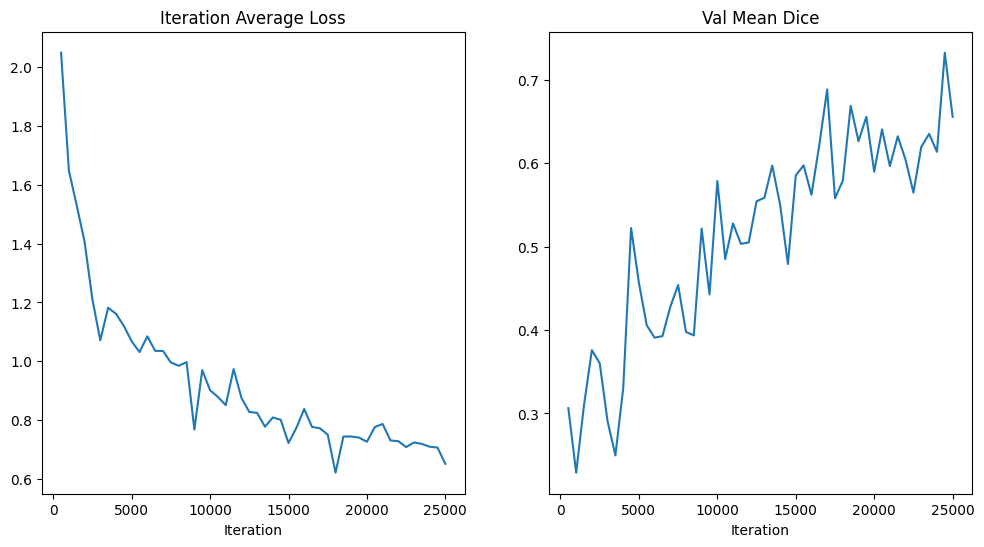

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()